In [1]:
import pandas as pd
import numpy as np
import pickle
from tabulate import tabulate
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import random 
import itertools
import seaborn as sns
from IPython.display import display, HTML, Markdown

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,roc_auc_score, classification_report, 
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import (
    RandomForestClassifier, StackingClassifier, VotingClassifier, GradientBoostingClassifier, 
    HistGradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, ClassifierMixin

from interpret.glassbox import ExplainableBoostingClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli 
from snapml import BoostingMachineClassifier  
from pytorch_tabnet.tab_model import TabNetClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tab_transformer_pytorch import TabTransformer 
from tab_transformer_pytorch import FTTransformer

2025-04-28 08:25:44.705307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745803544.722822  117524 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745803544.727938  117524 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-28 08:25:44.748663: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('data/cleaned_data.csv')
cols_to_keep = ['age', 
                'bmi',
                'map',
                'pulse_pressure',
                'gender',
                'cholesterol', 
                'gluc',
                'smoke', 
                'alco', 
                'active',
                'cardio'
                ]

df = df[cols_to_keep]

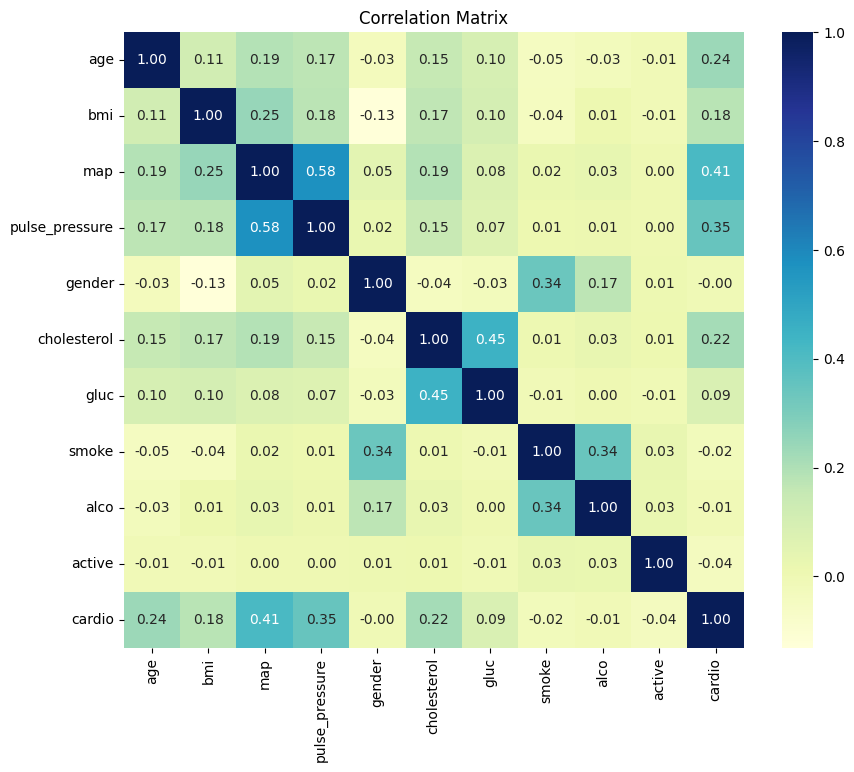

In [3]:
correlations = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlations, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [4]:
X = df.drop('cardio', axis=1)
y = df['cardio']

label_mapping = {0: 'Healthy', 1: 'Cardio Risk'}
target_names = [label_mapping[label] for label in y.unique()]

numerical_features = ['age', 'bmi', 'map', 'pulse_pressure']
ordinal_features = ['cholesterol', 'gluc']
binary_features = ['gender', 'smoke', 'alco', 'active']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Catatan: ColumnTransformer dengan remainder='passthrough' akan mengubah urutan kolom.
# Fitur yang discaling akan berada di awal, kemudian sisanya.
# Untuk mendapatkan nama kolom kembali (opsional), kita bisa menyusun ulang nama kolom sebagai berikut.
passthrough_features = [col for col in X.columns if col not in numerical_features]
transformed_feature_names = numerical_features + passthrough_features

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names)
print("Contoh data train setelah scaling:")
print(X_train_transformed_df.head())

Contoh data train setelah scaling:
        age       bmi       map  pulse_pressure  gender  cholesterol  gluc  \
0 -0.431181  0.556238 -0.357337       -0.453476     0.0          0.0   0.0   
1  1.645896  0.164370 -1.087684        0.508610     0.0          0.0   0.0   
2 -1.766444 -0.739102 -1.453955       -0.453476     0.0          0.0   0.0   
3 -1.469719  1.485835  1.653859        0.508610     1.0          0.0   0.0   
4 -0.134455 -0.388598 -0.357337       -0.453476     0.0          0.0   0.0   

   smoke  alco  active  
0    0.0   0.0     0.0  
1    0.0   0.0     0.0  
2    0.0   0.0     1.0  
3    1.0   1.0     1.0  
4    0.0   0.0     1.0  


In [5]:
x_train_np = np.array(X_train_transformed)
y_train_np = np.array(y_train)
x_test_np = np.array(X_test_transformed)
y_test_np = np.array(y_test)

In [6]:
class TabularDataset(Dataset):
    def __init__(self, X, categorical_indices, continuous_indices, targets):
        self.X = X
        self.categorical_indices = categorical_indices
        self.continuous_indices = continuous_indices
        self.targets = targets
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        row = self.X[idx]
        x_cont = row[self.continuous_indices].astype(np.float32)
        x_cat  = row[self.categorical_indices].astype(np.int64)
        target = np.array(self.targets[idx]).astype(np.float32)
        return x_cat, x_cont, target

class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model, epochs=None, lr=None, batch_size=None, device=None,
                continuous_indices=None, categorical_indices=None, classes_=None):
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.continuous_indices = continuous_indices
        self.categorical_indices = categorical_indices
        self.classes_ = classes_ if classes_ is not None else []
    
    def fit(self, X, y):
        if self.continuous_indices is None or self.categorical_indices is None:
            raise ValueError("continuous_indices and categorical_indices must be provided")
        train_dataset = TabularDataset(X, self.categorical_indices, self.continuous_indices, y)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.model.to(self.device)
        self.model.train()
        criterion = torch.nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            for batch in train_loader:
                x_cat, x_cont, targets = batch
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                targets = targets.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(x_cat, x_cont)
                loss = criterion(outputs, targets.float().unsqueeze(1))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            avg_loss = epoch_loss / len(train_loader)
            print(f"[Wrapper] Epoch {epoch+1}/{self.epochs}, Loss: {avg_loss:.4f}")
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        self.model.eval()
        dummy_targets = np.zeros(len(X))
        dataset = TabularDataset(X, self.categorical_indices, self.continuous_indices, dummy_targets)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        preds = []
        with torch.no_grad():
            for batch in loader:
                x_cat, x_cont, _ = batch
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                outputs = self.model(x_cat, x_cont)
                probs = torch.sigmoid(outputs)
                preds.append((probs.cpu().numpy() >= 0.5).astype(int))
        preds = np.concatenate(preds).squeeze()
        return preds

    def predict_proba(self, X):
        self.model.eval()
        dummy_targets = np.zeros(len(X))
        dataset = TabularDataset(X, self.categorical_indices, self.continuous_indices, dummy_targets)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        probas = []
        with torch.no_grad():
            for batch in loader:
                x_cat, x_cont, _ = batch
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                outputs = self.model(x_cat, x_cont)
                probs = torch.sigmoid(outputs)
                probas.append(probs.cpu().numpy())
        probas = np.concatenate(probas).squeeze()
        return np.vstack([1 - probas, probas]).T

    def get_params(self, deep=True):
        return {
            "model": self.model,
            "epochs": self.epochs,
            "lr": self.lr,
            "batch_size": self.batch_size,
            "device": self.device,
            "continuous_indices": self.continuous_indices,
            "categorical_indices": self.categorical_indices,
            "classes_": self.classes_
        }
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self



SUMMARY_HISTORY_TEST = []
SUMMARY_HISTORY_TRAIN = []

# — Style dicts for plotting —
JOURNAL_STYLE = {
    "font.family":     "serif",
    "font.serif":      ["Times New Roman", "CMU Serif"],
    "figure.dpi":      300,
    "axes.titlesize":  12,
    "axes.labelsize":  10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "axes.linewidth":  1.0,
}

ACC_STYLE = {
    **JOURNAL_STYLE,
    "axes.linewidth":  0.8,
    "xtick.direction": "in",
    "ytick.direction": "in",
}

def _style_ax(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
    
def evaluate_model(
    model,
    model_name="",
    x_train=x_train_np,
    y_train=y_train_np,
    x_test=x_test_np,
    y_test=y_test_np,
    label_mapping=target_names,
    roc_auc=False,
    fit=False,
    summary=False,
    plot_cm_roc=False,
    plot_acc=False
):
    """
    fit=True     -> call model.fit(x_train, y_train) internally
    fit=False    -> assume model is already fitted externally
    summary=False-> only save summary data without printing
    summary=True -> display cumulative summary tables as HTML
    """
    # 1) Fit the model if requested
    if fit:
        model.fit(x_train, y_train)

    # 2) Make predictions & predict probabilities
    y_pred_train  = model.predict(x_train)
    y_pred_test   = model.predict(x_test)
    y_proba_train = model.predict_proba(x_train)[:, 1]
    y_proba_test  = model.predict_proba(x_test)[:, 1]

    # 3) Compute metrics for both Train and Test
    metrics = {}
    for split, y_true, y_pred, y_probs in [
        ("Train", y_train, y_pred_train, y_proba_train),
        ("Test",  y_test,  y_pred_test,  y_proba_test)
    ]:
        metrics[f"{split}_Acc"]       = accuracy_score(y_true, y_pred)
        metrics[f"{split}_AUC"]       = roc_auc_score(y_true, y_probs)
        rpt = classification_report(y_true, y_pred, output_dict=True)
        metrics[f"{split}_Precision"] = rpt["weighted avg"]["precision"]
        metrics[f"{split}_Recall"]    = rpt["weighted avg"]["recall"]
        metrics[f"{split}_F1"]        = rpt["weighted avg"]["f1-score"]

    # 4) Print detailed classification reports with centered title
    BOLD, RESET = "\033[1m", "\033[0m"
    title = f"=== {model_name} Results ==="
    print("\n" + BOLD + title.center(60) + RESET)
    for split in ("Test", "Train"):
        print(f"{split} Acc: {metrics[f'{split}_Acc']:.4f}, AUC: {metrics[f'{split}_AUC']:.4f}")
        print(classification_report(
            y_test if split=="Test" else y_train,
            y_pred_test if split=="Test" else y_pred_train,
            digits=4
        ))
    print(
        "✅ No significant overfitting\n"
        if not (
            metrics["Train_Acc"] > metrics["Test_Acc"] + 0.05
            or metrics["Train_AUC"] > metrics["Test_AUC"] + 0.05
        )
        else "⚠️ Overfitting suspected\n"
    )

    # 5) Append current metrics to history lists
    SUMMARY_HISTORY_TEST[:]  = [
        d for d in SUMMARY_HISTORY_TEST  if d["Algorithm"] != model_name
    ]
    SUMMARY_HISTORY_TRAIN[:] = [
        d for d in SUMMARY_HISTORY_TRAIN if d["Algorithm"] != model_name
    ]

    # Lalu append yang baru
    SUMMARY_HISTORY_TEST.append({
        "Algorithm": model_name,
        "Accuracy":  metrics["Test_Acc"],
        "Precision": metrics["Test_Precision"],
        "Recall":    metrics["Test_Recall"],
        "F1-Score":  metrics["Test_F1"],
        "AUC":       metrics["Test_AUC"]
    })
    SUMMARY_HISTORY_TRAIN.append({
        "Algorithm": model_name,
        "Accuracy":  metrics["Train_Acc"],
        "Precision": metrics["Train_Precision"],
        "Recall":    metrics["Train_Recall"],
        "F1-Score":  metrics["Train_F1"],
        "AUC":       metrics["Train_AUC"]
    })

    # 6) Display cumulative summary tables as HTML when requested
    if summary:
        import pandas as pd
        from IPython.display import display, HTML

        df_test  = pd.DataFrame(SUMMARY_HISTORY_TEST)
        df_train = pd.DataFrame(SUMMARY_HISTORY_TRAIN)

        if isinstance(summary, dict):
            keep = [model_name] + list(summary.keys())
        else:
            keep = [model_name]

        df_test  = df_test[df_test["Algorithm"].isin(keep)]
        df_train = df_train[df_train["Algorithm"].isin(keep)]

        display(HTML(
            "<h4>Cumulative Summary Table – Test Metrics</h4>"
            + df_test.to_html(index=False, float_format="%.4f")
        ))
        display(HTML(
            "<h4>Cumulative Summary Table – Train Metrics</h4>"
            + df_train.to_html(index=False, float_format="%.4f")
        ))
        
    # 7) Plot Confusion Matrix & ROC Curves if requested
    if plot_cm_roc:
        plt.rcParams.update(JOURNAL_STYLE)
        labels = list(label_mapping) if label_mapping is not None else ["0","1"]
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        def _plot_cm(ax, y_t, y_p, title):
            disp = ConfusionMatrixDisplay(
                confusion_matrix(y_t, y_p), display_labels=labels
            )
            disp.plot(
                ax=ax,
                values_format='d',
                cmap="Blues",
                colorbar=True,
                text_kw={"fontsize": 12}
            )
            n = len(labels)
            ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
            ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
            ax.grid(which='minor', color='black', linestyle='-')  # fine for cell borders

            # === REMOVE THOSE DASHED HORIZONTAL LINES ===
            ax.grid(False)  # turn _off_ all grid lines
            # Or if you want only the vertical cell borders, do:
            # ax.grid(axis='x', which='minor', color='black', linestyle='-')
            ax.tick_params(which='minor', length=0)

            ax.set_title(f"{model_name} – {title}")
            ax.set_xlabel("Predicted label")
            ax.set_ylabel("True label")

            # keep your spine styling
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

        def _plot_roc(ax, y_t, y_p, title, auc_val):
            fpr, tpr, _ = roc_curve(y_t, y_p)
            ax.plot(fpr, tpr, lw=2, label=f"AUC = {auc_val:.4f}")
            ax.plot([0,1], [0,1], "--", lw=1, color="gray")
            ax.set_title(f"{model_name} – {title}")
            ax.set_xlabel("False Positive Rate (FPR)")
            ax.set_ylabel("True Positive Rate (TPR)")
            ax.legend(frameon=True, loc="lower right")
            _style_ax(ax)

        _plot_cm(axes[0,0], y_train,      y_pred_train,  "Confusion Matrix (Train)")
        _plot_roc(axes[0,1], y_train,      y_proba_train, "ROC Curve (Train)", metrics["Train_AUC"])
        _plot_cm(axes[1,0], y_test,       y_pred_test,   "Confusion Matrix (Test)")
        _plot_roc(axes[1,1], y_test,       y_proba_test,  "ROC Curve (Test)",  metrics["Test_AUC"])

        plt.tight_layout()
        plt.show()

    # 8) ROC Comparison (boolean or dict)
    if roc_auc:
        plt.rcParams.update(JOURNAL_STYLE)

        # 1) Decide which models to include
        if isinstance(roc_auc, dict):
            # first the extra models, then the primary one
            roc_items = list(roc_auc.items()) + [(model_name, model)]
        else:
            # only the primary model
            roc_items = [(model_name, model)]

        n_models = len(roc_items)
        base_tick     = 10
        tick_fontsize = max(6,  base_tick - n_models//2)
        title_fontsize= max(10, base_tick + 2 - n_models//2)
        label_fontsize= max(8,  base_tick - n_models//3)
        legend_fontsize = max(6, base_tick - n_models//2)

        fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

        # 2) Plot extra models with thinner lines
        for nm, m in roc_items[:-1]:
            pr = m.predict_proba(x_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, pr)
            auc_val = roc_auc_score(y_test, pr)
            ax.plot(fpr, tpr, lw=1.5, label=f"{nm} (AUC={auc_val:.4f})")

        # 3) Plot primary model with thicker line
        main_label = roc_items[-1][0]
        ax.plot(
            *roc_curve(y_test, y_proba_test)[:2],
            lw=2,
            label=f"{main_label} (AUC={metrics['Test_AUC']:.4f})"
        )

        # 4) Diagonal reference and styling (unchanged)
        ax.plot([0, 1], [0, 1], linestyle="--", lw=1, color="gray")
        ax.set_xlabel("False Positive Rate (FPR)", labelpad=4, fontsize=label_fontsize)
        ax.set_ylabel("True Positive Rate (TPR)",  labelpad=4, fontsize=label_fontsize)
        ax.set_title("ROC Curve Comparison", pad=6,     fontsize=title_fontsize)
        ax.tick_params(axis='x', labelsize=tick_fontsize)
        ax.tick_params(axis='y', labelsize=tick_fontsize)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)

        # 5) Legend with background
        ax.legend(
            frameon=True,
            facecolor="white",
            edgecolor="black",
            framealpha=0.9,
            loc="lower right",
            fontsize=legend_fontsize
        )

        plt.show()

        
    # 9) Plot Accuracy bar chart (boolean or dict)
    if plot_acc:
        plt.rcParams.update(ACC_STYLE)

        # 1) Decide which algos to plot
        if isinstance(plot_acc, dict):
            # dict   → plot those keys, then the primary model
            names  = list(plot_acc.keys()) + [model_name]
            models = list(plot_acc.values()) + [model]
        elif plot_acc is True:
            # True   → only the primary model
            names  = [model_name]
            models = [model]
        else:
            # None or False  → skip plotting entirely
            return metrics

        # 2) Compute accuracies
        train_acc = [accuracy_score(y_train, m.predict(x_train)) for m in models]
        test_acc  = [accuracy_score(y_test,  m.predict(x_test))  for m in models]

        # 3) Set up dynamic figure size
        n = len(names)
        fig_width = max(6, n * 0.5)
        fig, ax = plt.subplots(figsize=(fig_width, 4))

        x = np.arange(n)
        w = 0.35

        bars_tr = ax.bar(x - w/2, train_acc, w, label="Train",
                        color="#4C72B0", edgecolor="black", linewidth=0.8)
        bars_te = ax.bar(x + w/2, test_acc,  w, label="Test",
                        color="#55A868", edgecolor="black", linewidth=0.8)

        # 4) Add percentage labels
        for bar in bars_tr + bars_te:
            h = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2,
                    h + 0.005, f"{h*100:.2f}%",
                    ha="center", va="bottom", fontsize=4.5)

        # 5) Configure ticks & styling
        tick_fs = 8 if n <= 9 else max(6, 12 - n//2)
        ax.set_xticks(x)
        ax.set_xticklabels(names, rotation=45, ha="right", fontsize=tick_fs)
        ax.tick_params(axis='y', labelsize=tick_fs)
        ax.set_ylabel("Accuracy (%)", fontsize=tick_fs+1)
        ax.set_ylim(0, 1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)
        ax.legend(frameon=True, loc="upper left", fontsize=tick_fs)

        plt.tight_layout()
        plt.show()


    return metrics

# Clear histories before first run
# SUMMARY_HISTORY_TRAIN.clear()
# SUMMARY_HISTORY_TEST.clear()


                  === LightGBM Results ===                  
Test Acc: 0.7383, AUC: 0.8019
              precision    recall  f1-score   support

           0     0.7230    0.7820    0.7513      6321
           1     0.7567    0.6935    0.7237      6180

    accuracy                         0.7383     12501
   macro avg     0.7398    0.7378    0.7375     12501
weighted avg     0.7397    0.7383    0.7377     12501

Train Acc: 0.7417, AUC: 0.8155
              precision    recall  f1-score   support

           0     0.7254    0.7882    0.7555     25313
           1     0.7617    0.6941    0.7263     24688

    accuracy                         0.7417     50001
   macro avg     0.7435    0.7411    0.7409     50001
weighted avg     0.7433    0.7417    0.7411     50001

✅ No significant overfitting



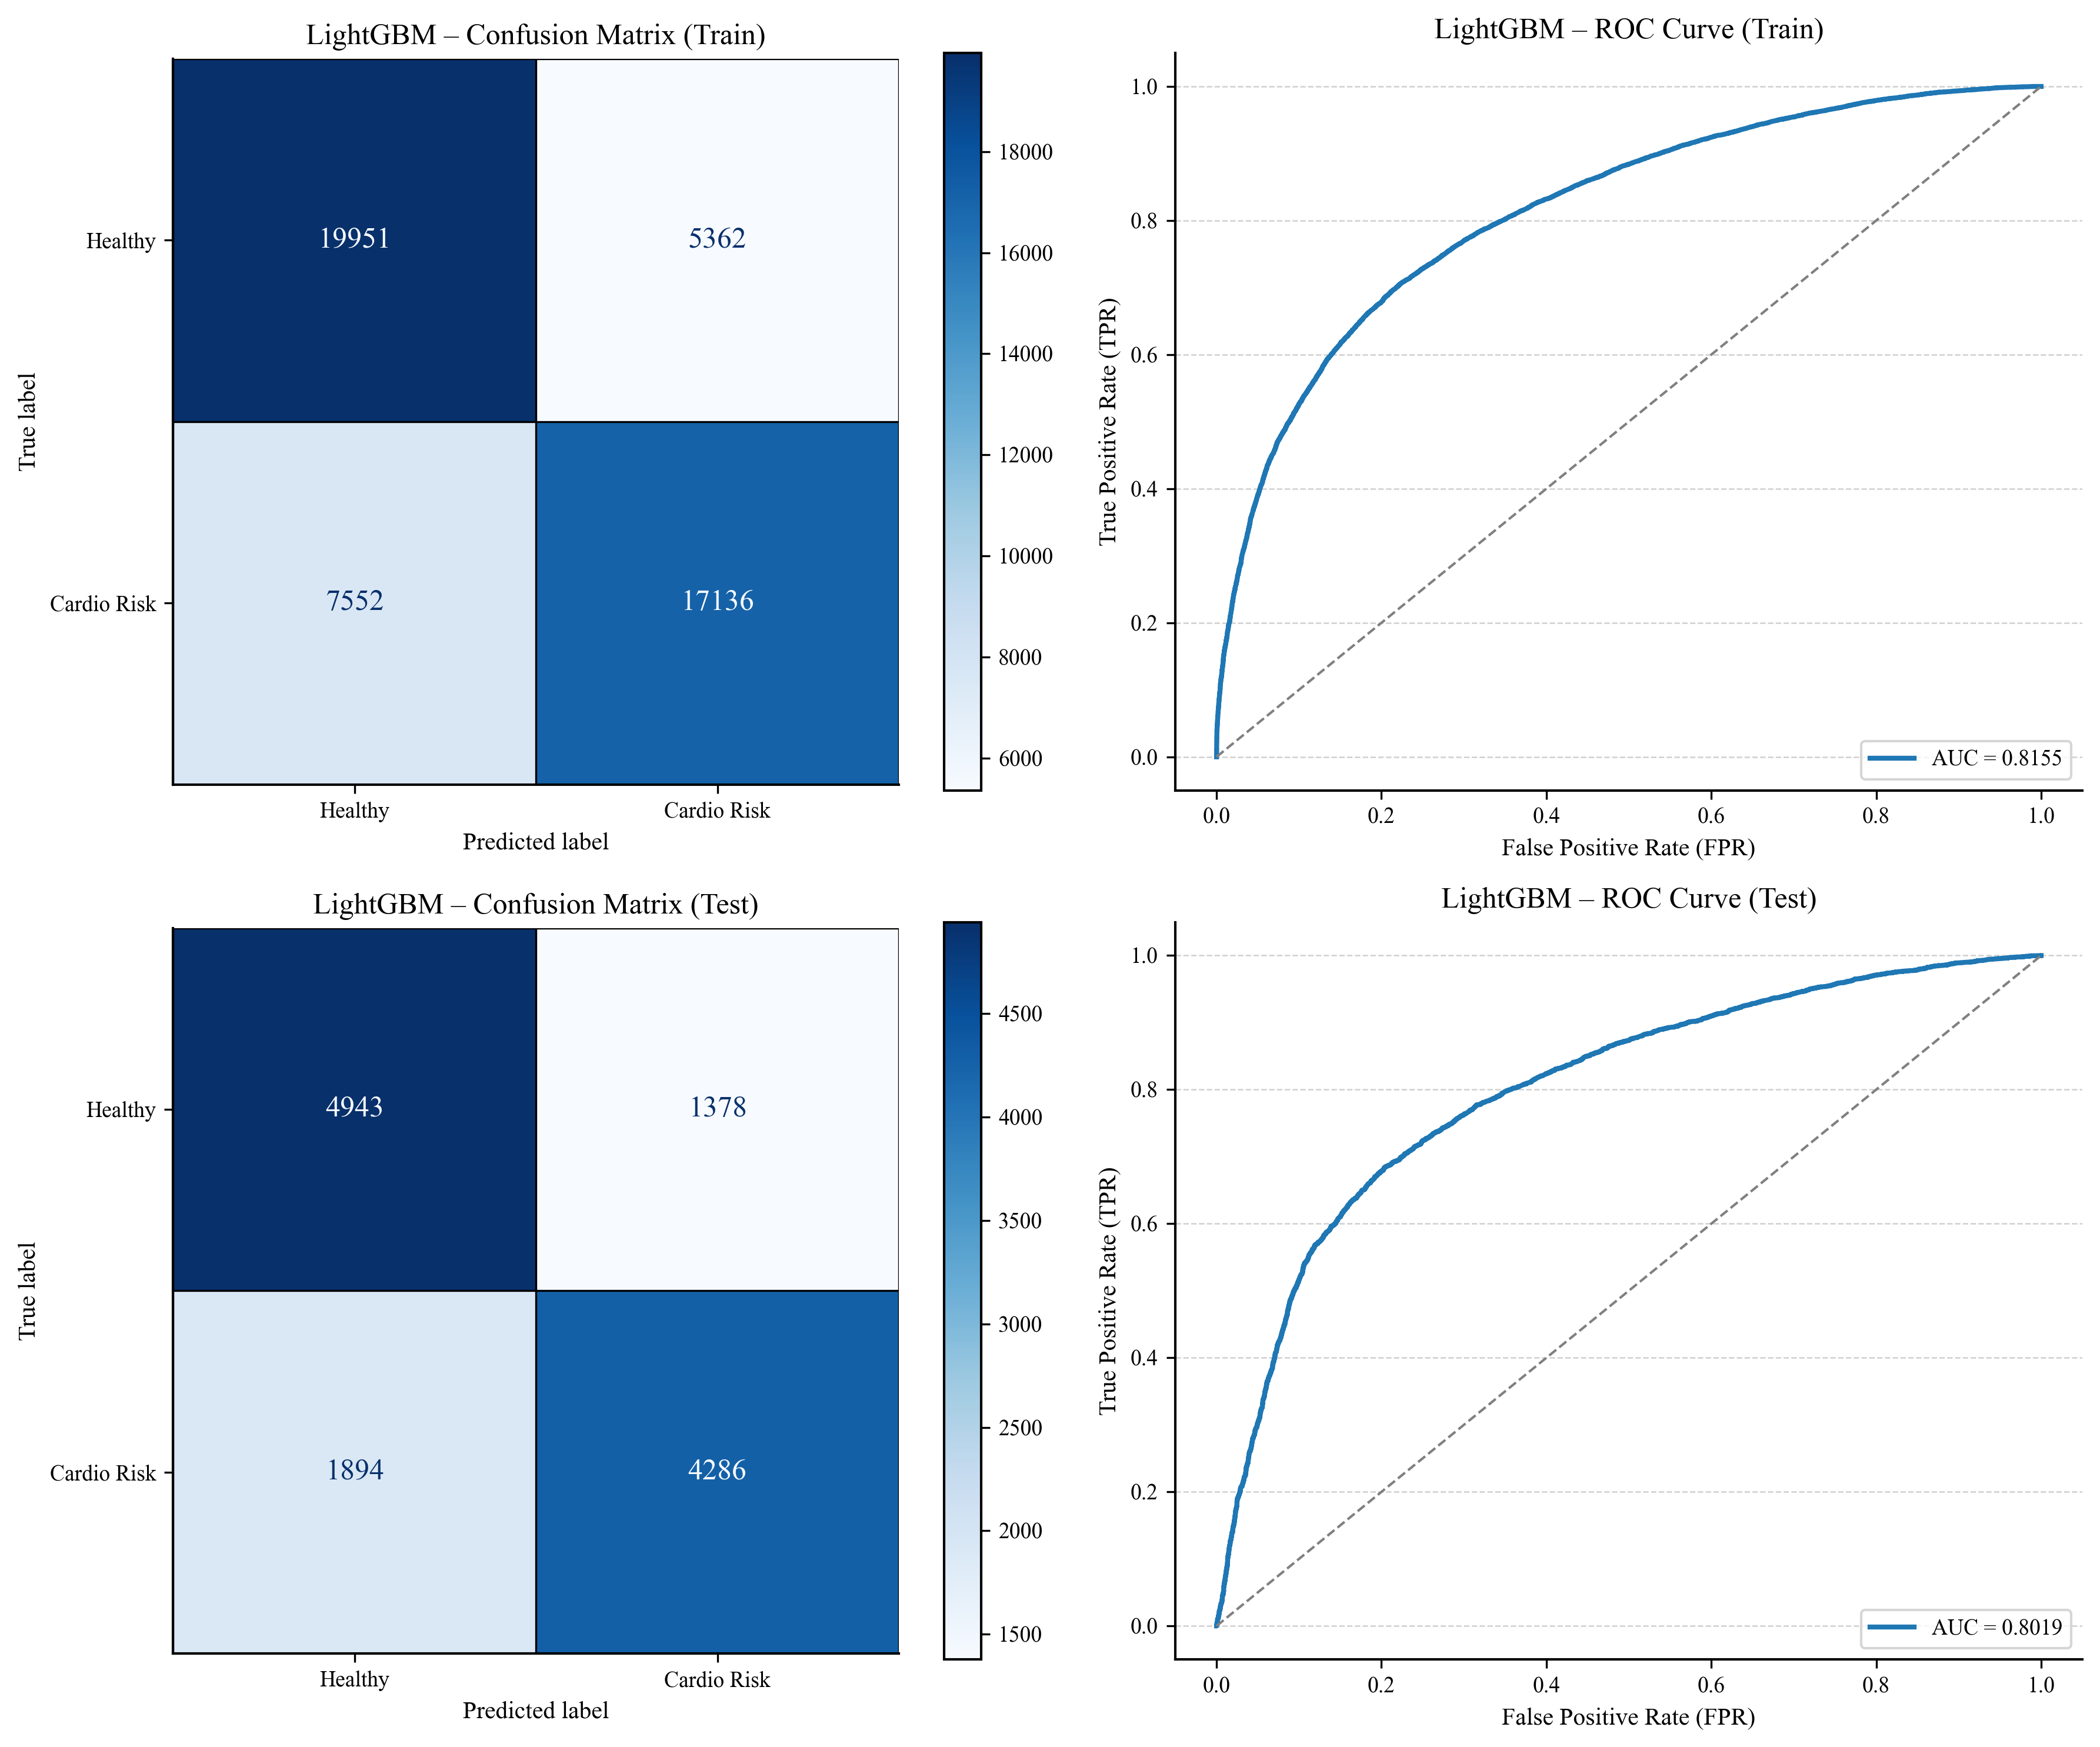

In [7]:
# best_params = {
#     'n_estimators': 233,
#     'learning_rate': 0.019519792757748358,
#     'num_leaves': 41,
#     'max_depth': 15,
#     'subsample': 0.758484089588373,
#     'colsample_bytree': 0.9592852139230149,
#     'random_state': 6580,
#     'verbose' : -1
# }

lgbm_model = LGBMClassifier(verbose=-1)
    
lgbm_model.fit(x_train_np, y_train_np)

lgbm_results = evaluate_model(
    model=lgbm_model,
    model_name="LightGBM",
    plot_cm_roc=True
)

lgbm_results;


                  === CatBoost Results ===                  
Test Acc: 0.7361, AUC: 0.8011
              precision    recall  f1-score   support

           0     0.7226    0.7760    0.7483      6321
           1     0.7521    0.6953    0.7226      6180

    accuracy                         0.7361     12501
   macro avg     0.7374    0.7356    0.7355     12501
weighted avg     0.7372    0.7361    0.7356     12501

Train Acc: 0.7484, AUC: 0.8248
              precision    recall  f1-score   support

           0     0.7326    0.7921    0.7612     25313
           1     0.7675    0.7035    0.7341     24688

    accuracy                         0.7484     50001
   macro avg     0.7500    0.7478    0.7476     50001
weighted avg     0.7498    0.7484    0.7478     50001

✅ No significant overfitting



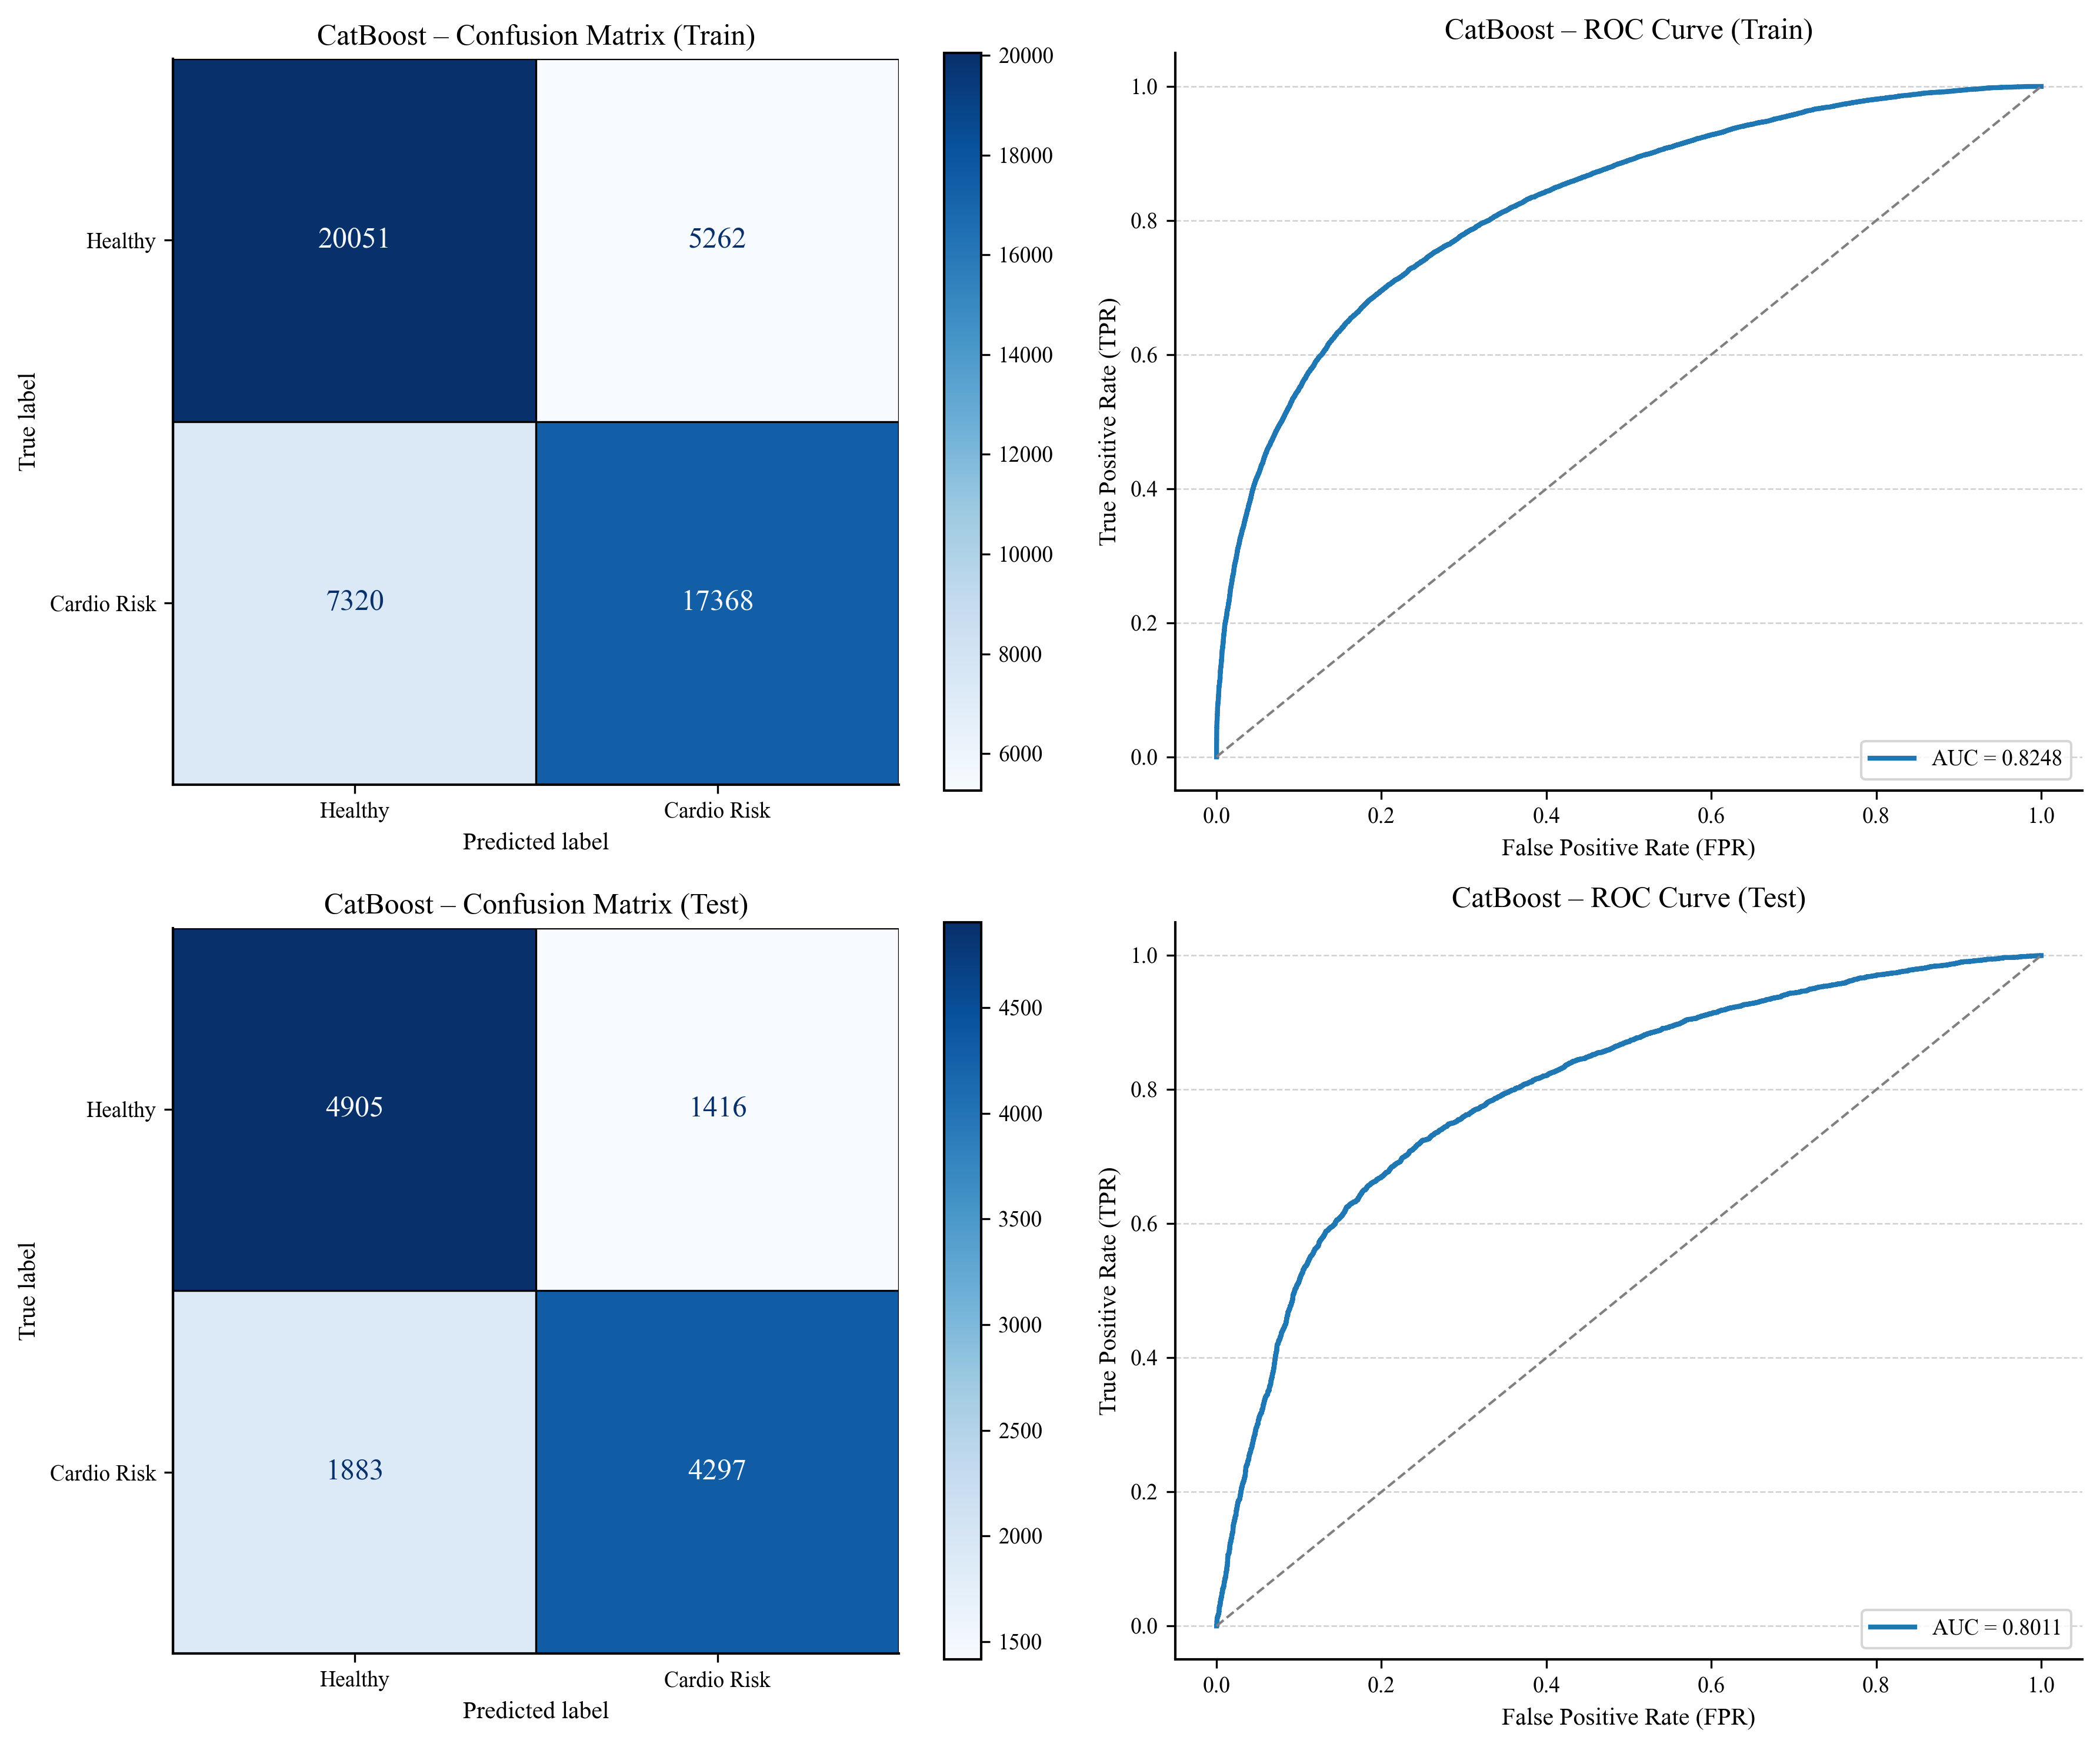

In [8]:
# best_params = {
#     'iterations': 680, 
#     'learning_rate': 0.01040286438048717, 
#     'depth': 9, 
#     'l2_leaf_reg': 0.10424693387826892, 
#     'border_count': 220, 
#     'random_strength': 0.015513247584661348, 
#     'bagging_temperature': 0.2020691195100053, 
#     'random_seed': 7801,
#     'verbose': False
#     }


catb_model = CatBoostClassifier(verbose=False)

catb_model.fit(x_train_np, y_train_np)

catb_results = evaluate_model(
    model               = catb_model, 
    model_name          = "CatBoost", 
    plot_cm_roc         = True
)

catb_results;


           === Hist Gradient Boosting Results ===           
Test Acc: 0.7377, AUC: 0.8013
              precision    recall  f1-score   support

           0     0.7245    0.7766    0.7496      6321
           1     0.7534    0.6979    0.7246      6180

    accuracy                         0.7377     12501
   macro avg     0.7389    0.7373    0.7371     12501
weighted avg     0.7388    0.7377    0.7372     12501

Train Acc: 0.7380, AUC: 0.8089
              precision    recall  f1-score   support

           0     0.7236    0.7807    0.7510     25313
           1     0.7553    0.6942    0.7235     24688

    accuracy                         0.7380     50001
   macro avg     0.7395    0.7374    0.7373     50001
weighted avg     0.7393    0.7380    0.7374     50001

✅ No significant overfitting



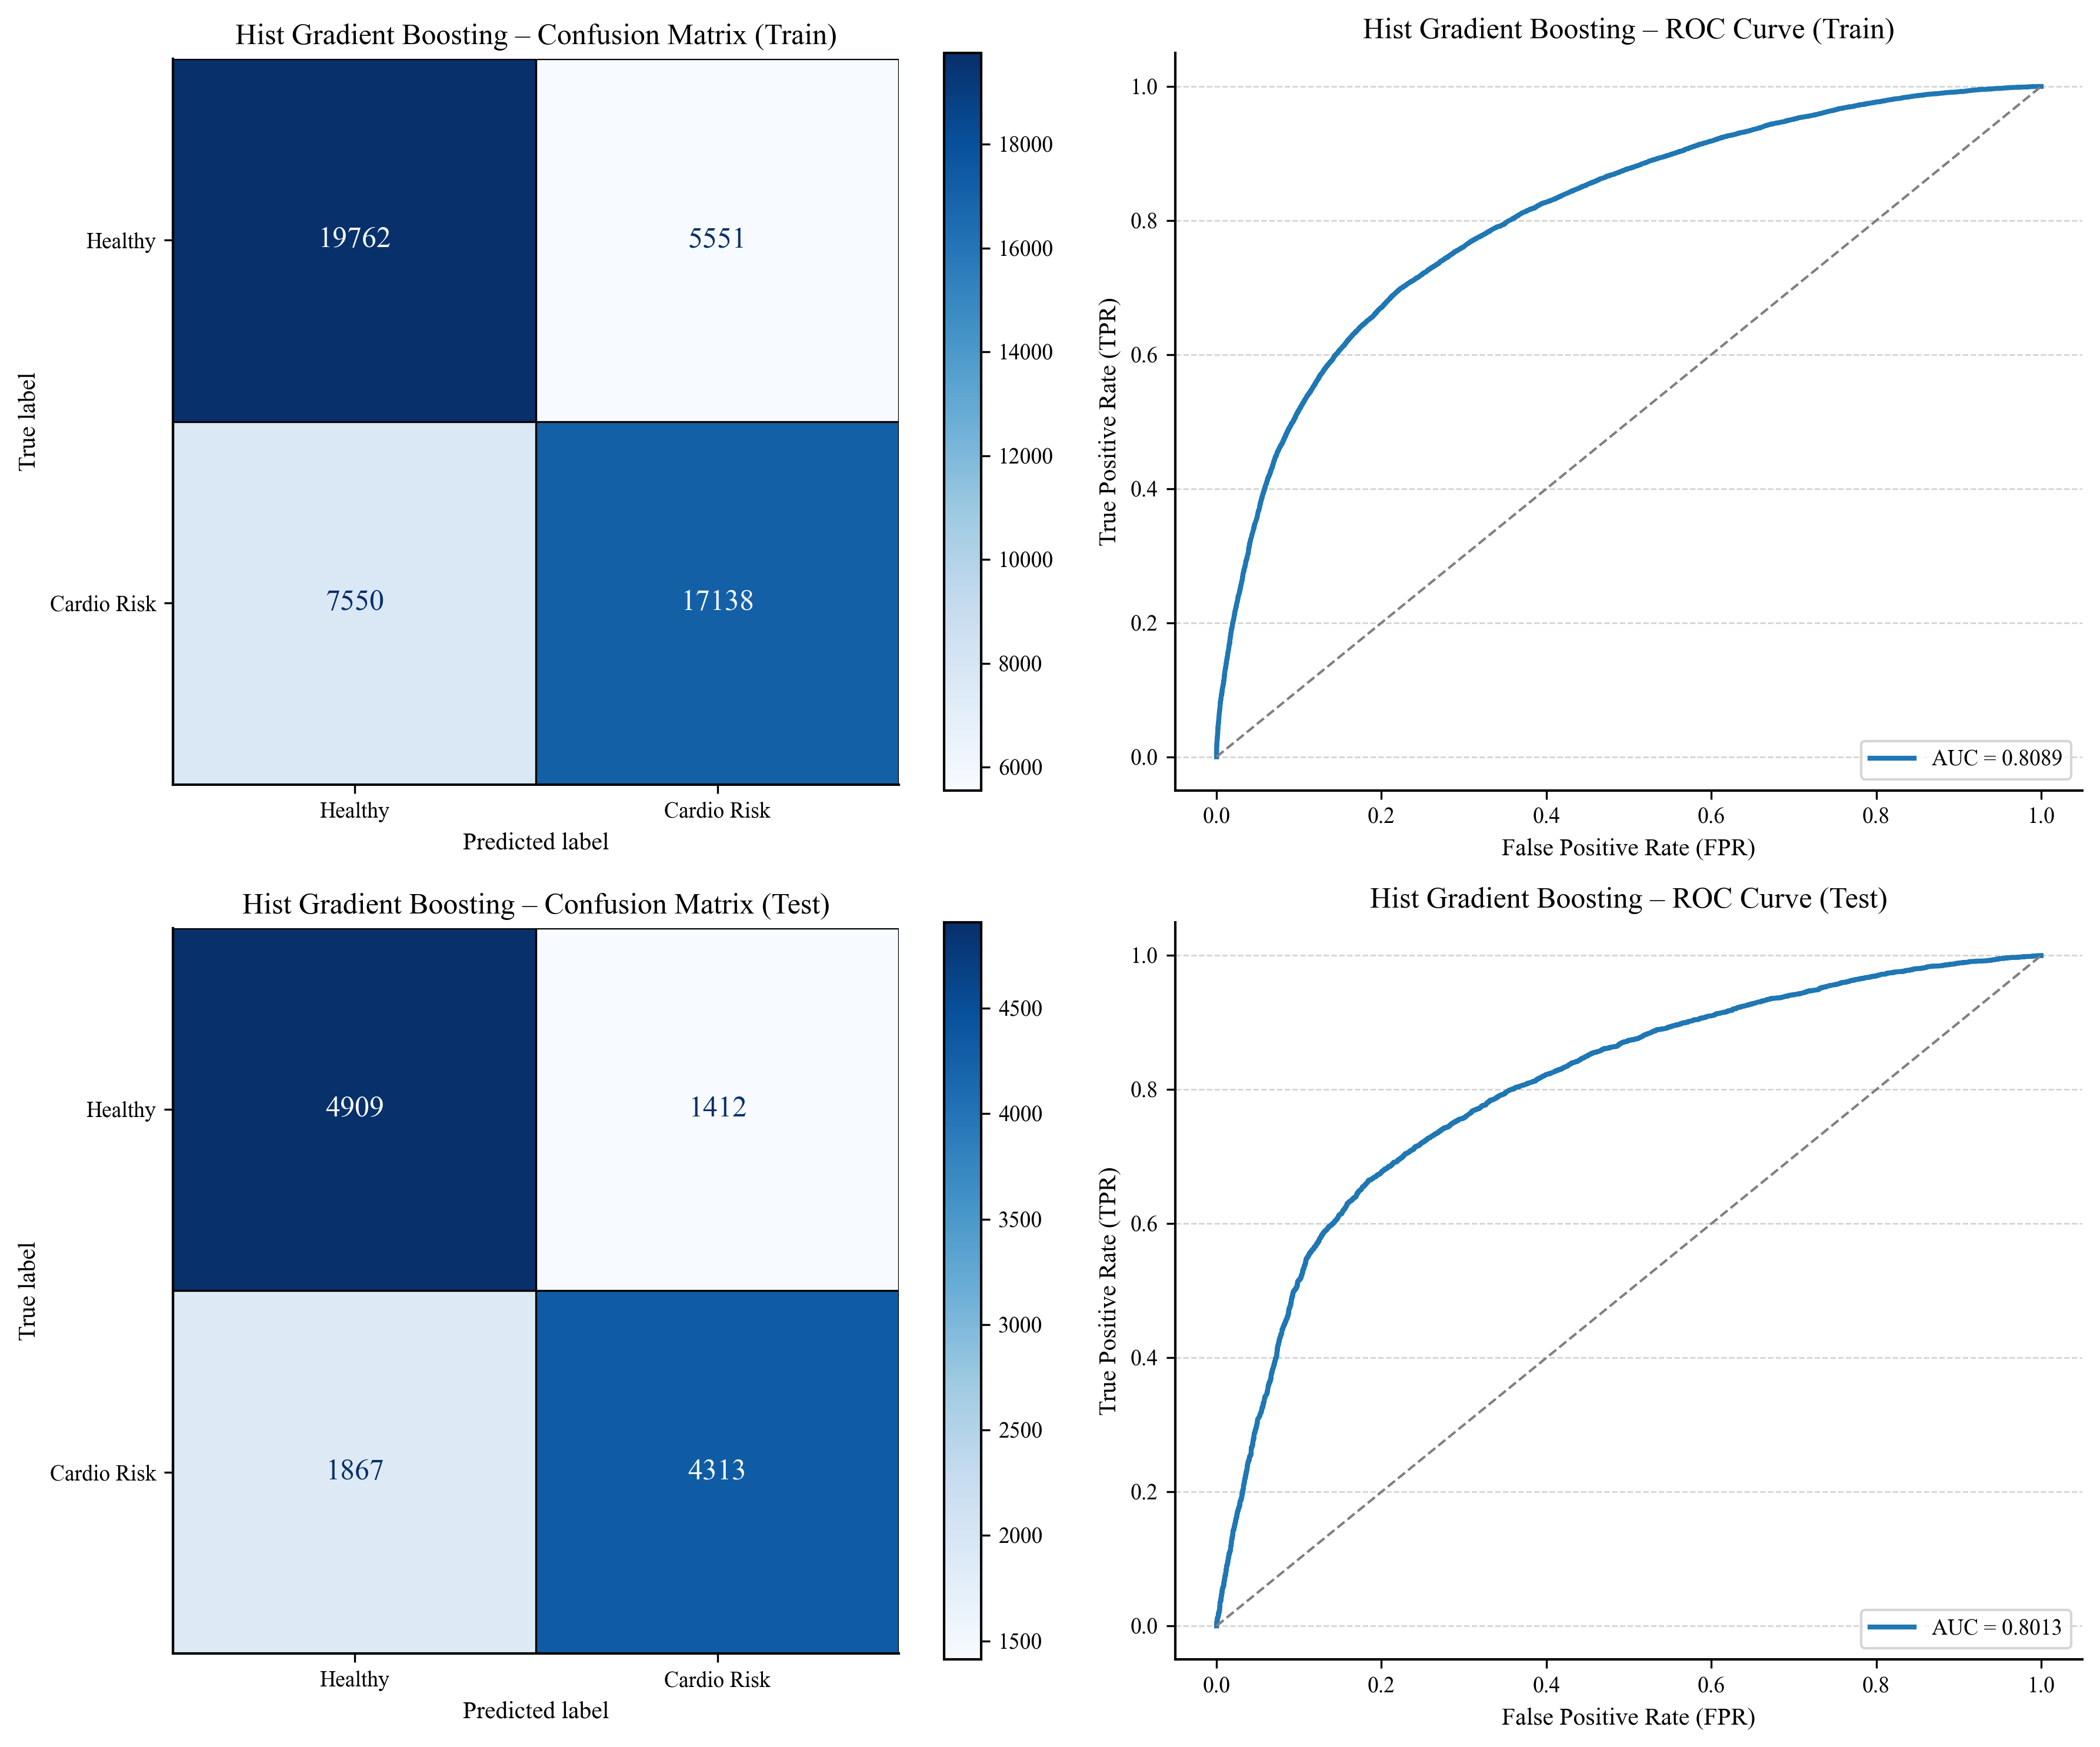

In [9]:

# best_params = {
#     'max_iter': 409, 
#     'learning_rate': 0.01947652219796748, 
#     'max_leaf_nodes': 36, 
#     'min_samples_leaf': 28, 
#     'l2_regularization': 4.313378648780895e-06, 
#     'random_state': 8404
#             }

hgrb_model =  HistGradientBoostingClassifier(random_state=42)

hgrb_model.fit(x_train_np, y_train_np)

hgrb_results = evaluate_model(
    model               = hgrb_model, 
    model_name          = "Hist Gradient Boosting", 
    plot_cm_roc         = True
)

hgrb_results;

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



                  === AdaBoost Results ===                  
Test Acc: 0.7326, AUC: 0.7942
              precision    recall  f1-score   support

           0     0.7074    0.8035    0.7524      6321
           1     0.7666    0.6600    0.7093      6180

    accuracy                         0.7326     12501
   macro avg     0.7370    0.7318    0.7309     12501
weighted avg     0.7366    0.7326    0.7311     12501

Train Acc: 0.7236, AUC: 0.7886
              precision    recall  f1-score   support

           0     0.6985    0.7988    0.7453     25313
           1     0.7581    0.6465    0.6979     24688

    accuracy                         0.7236     50001
   macro avg     0.7283    0.7227    0.7216     50001
weighted avg     0.7279    0.7236    0.7219     50001

✅ No significant overfitting



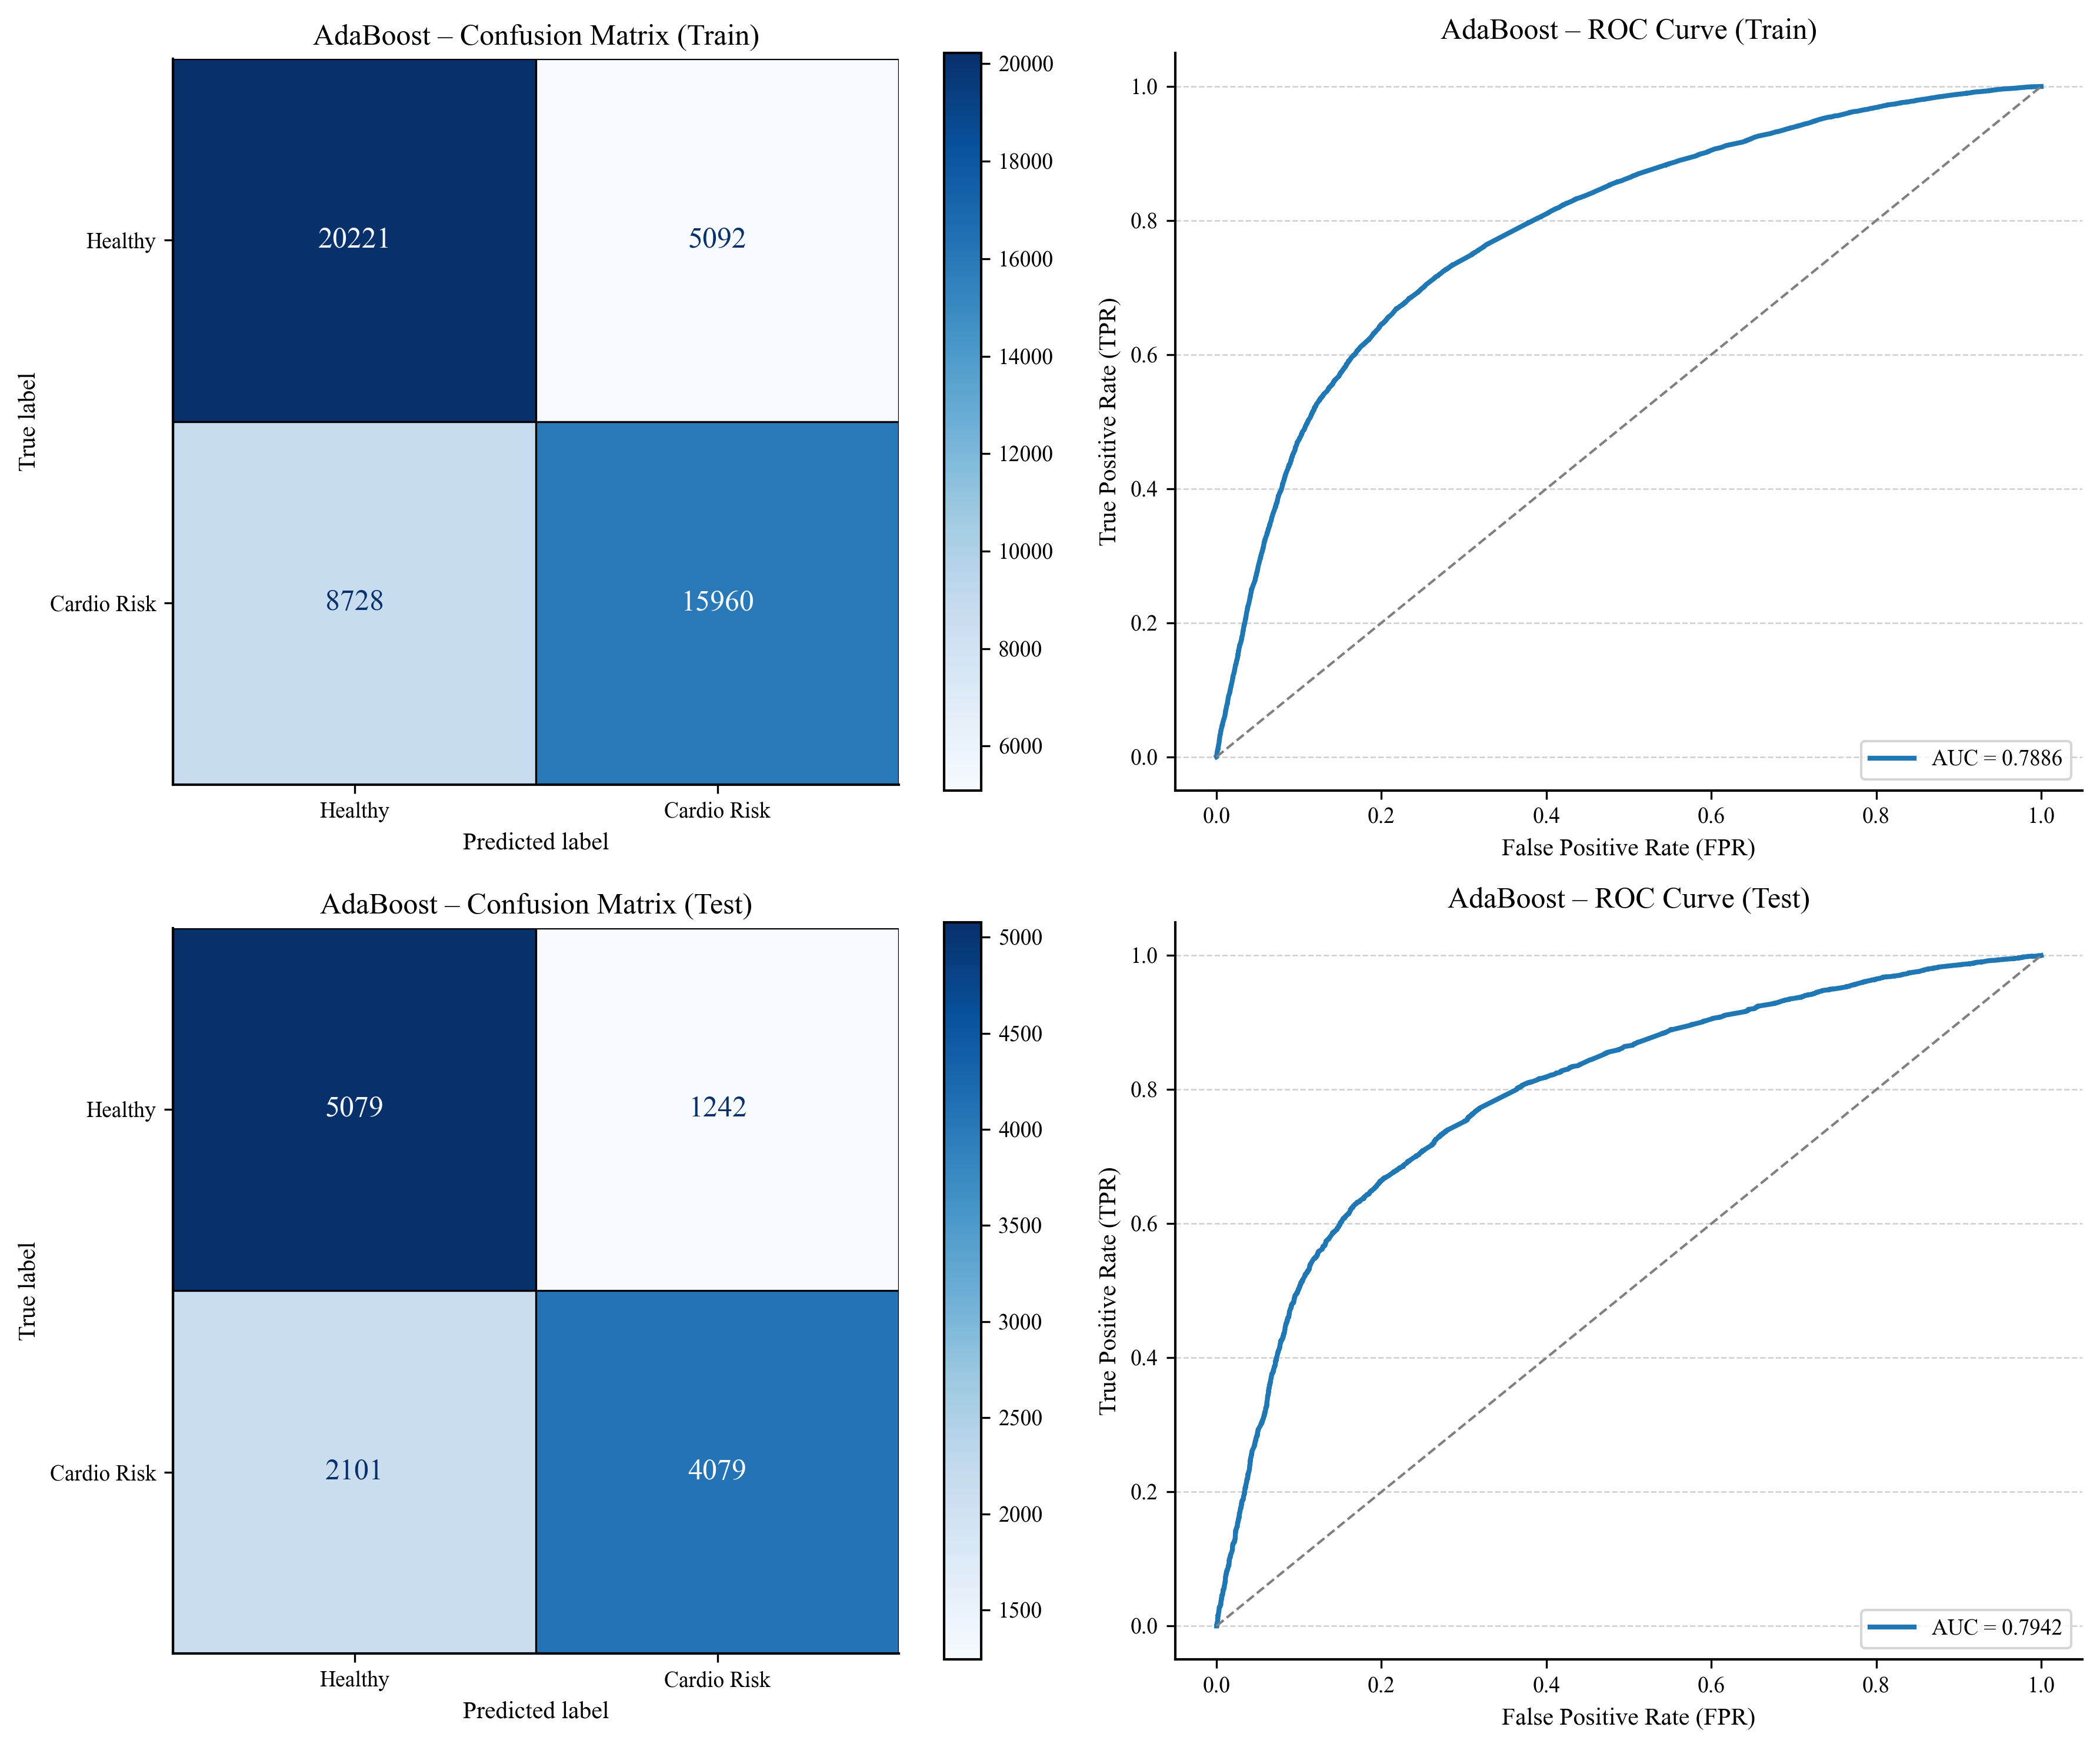

In [10]:
# best_params = {'n_estimators': 478, 'learning_rate': 0.17278746878628695, 'random_state': 5660}

adb_model = AdaBoostClassifier()

adb_model.fit(x_train_np, y_train_np)

adb_results = evaluate_model(
    model               = adb_model, 
    model_name          = "AdaBoost", 
    plot_cm_roc         = True
)

adb_results;

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)



                   === TabNet Results ===                   
Test Acc: 0.7359, AUC: 0.7992
              precision    recall  f1-score   support

           0     0.7257    0.7678    0.7462      6321
           1     0.7475    0.7032    0.7247      6180

    accuracy                         0.7359     12501
   macro avg     0.7366    0.7355    0.7354     12501
weighted avg     0.7365    0.7359    0.7355     12501

Train Acc: 0.7334, AUC: 0.7991
              precision    recall  f1-score   support

           0     0.7215    0.7709    0.7454     25313
           1     0.7474    0.6950    0.7202     24688

    accuracy                         0.7334     50001
   macro avg     0.7345    0.7329    0.7328     50001
weighted avg     0.7343    0.7334    0.7330     50001

✅ No significant overfitting



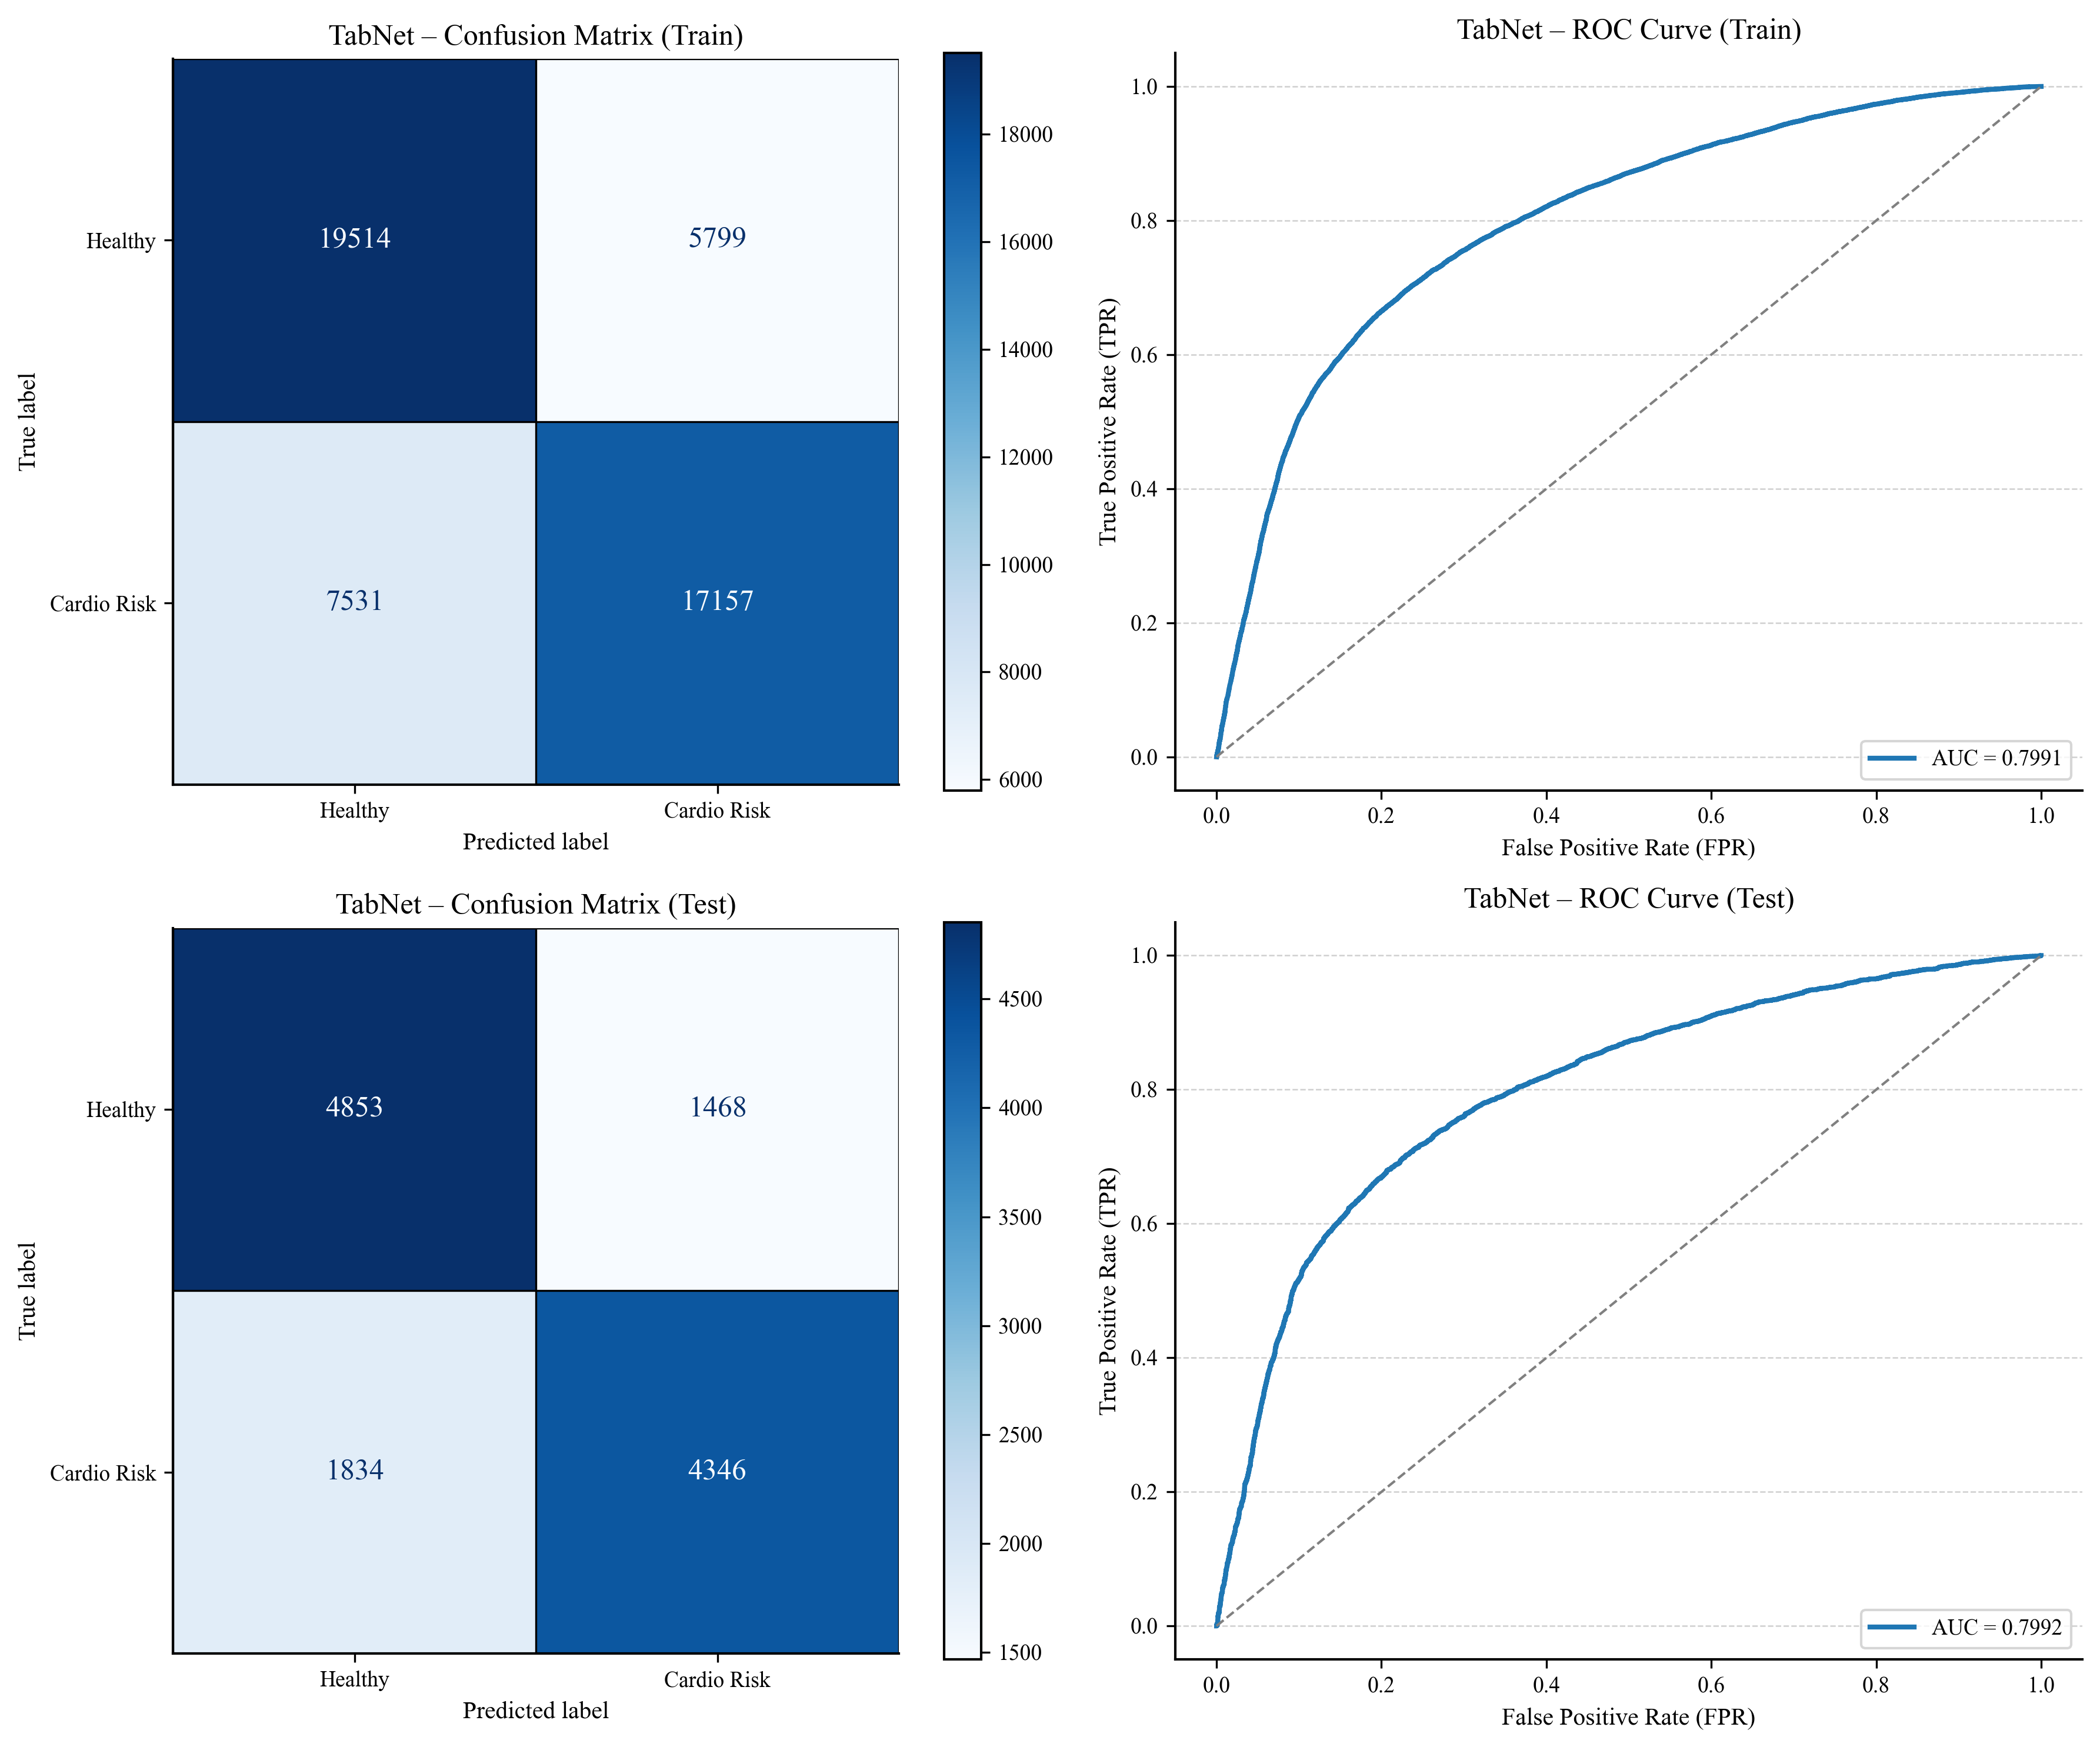

In [11]:
tabnet_model = TabNetClassifier(verbose=0)

tabnet_model.fit(x_train_np, y_train_np)

tabnet_results = evaluate_model(
    model               = tabnet_model, 
    model_name          = "TabNet", 
    plot_cm_roc         = True
)

tabnet_results;

In [12]:
continuous_indices = list(range(len(numerical_features)))  
categorical_indices = list(range(len(numerical_features), len(transformed_feature_names)))  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[Wrapper] Epoch 1/10, Loss: 0.6620
[Wrapper] Epoch 2/10, Loss: 0.6529
[Wrapper] Epoch 3/10, Loss: 0.6510
[Wrapper] Epoch 4/10, Loss: 0.6486
[Wrapper] Epoch 5/10, Loss: 0.6457
[Wrapper] Epoch 6/10, Loss: 0.6408
[Wrapper] Epoch 7/10, Loss: 0.6348
[Wrapper] Epoch 8/10, Loss: 0.6304
[Wrapper] Epoch 9/10, Loss: 0.6285
[Wrapper] Epoch 10/10, Loss: 0.6256

               === TabTransformer Results ===               
Test Acc: 0.6628, AUC: 0.7120
              precision    recall  f1-score   support

           0     0.6459    0.7375    0.6887      6321
           1     0.6860    0.5864    0.6323      6180

    accuracy                         0.6628     12501
   macro avg     0.6659    0.6620    0.6605     12501
weighted avg     0.6657    0.6628    0.6608     12501

Train Acc: 0.6619, AUC: 0.7108
              precision    recall  f1-score   support

           0     0.6442    0.7420    0.6896     25313
           1     0.6867    0.5798    0.6287     24688

    accuracy                       

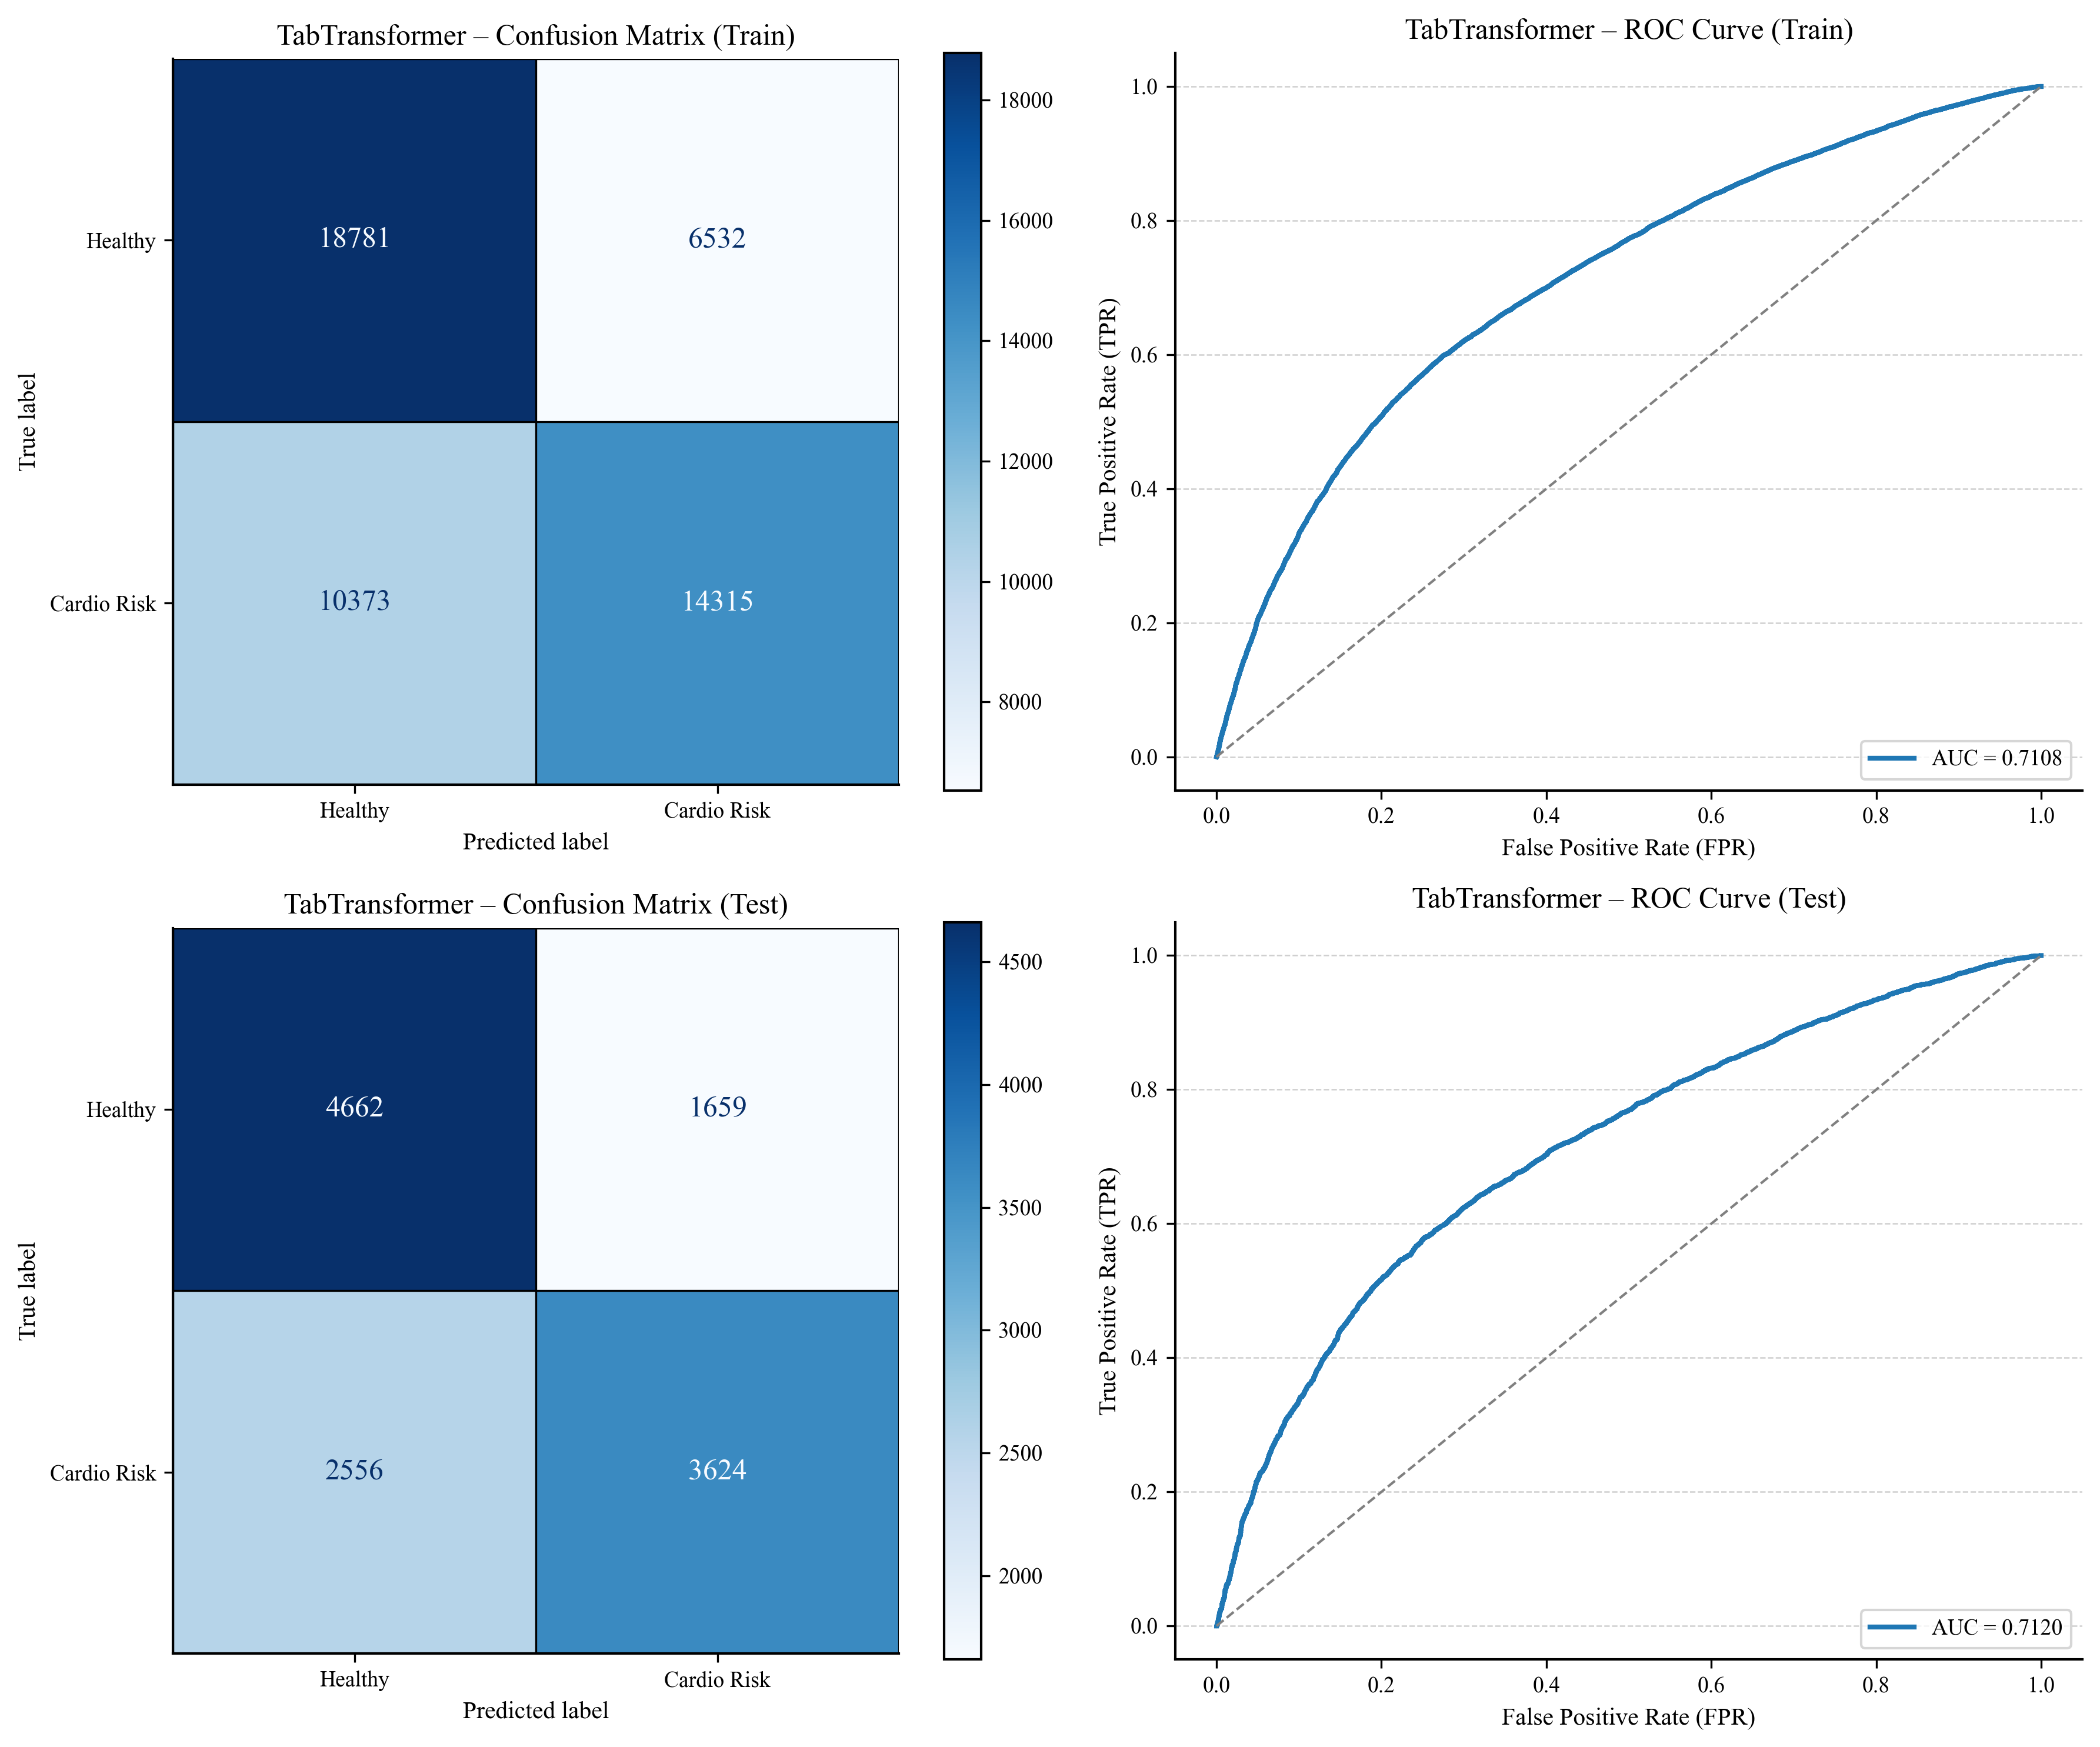

In [13]:
tabtf_model = TabTransformer(
    categories            = (3, 3, 2, 2, 2, 2), 
    num_continuous        = len(continuous_indices),
    dim                   = 32,
    dim_out               = 1,
    depth                 = 6,
    heads                 = 8,
    attn_dropout          = 0.1,
    ff_dropout            = 0.1,
    mlp_hidden_mults      = (4, 2),
    mlp_act               = nn.ReLU(),
    continuous_mean_std   = None
).to(device)


tabtf_wrapper = PyTorchClassifier(
    model                 = tabtf_model,
    epochs                = 10,
    batch_size            = 32,
    lr                    = 1e-3,
    categorical_indices = categorical_indices,
    continuous_indices  = continuous_indices,
)

tabtf_wrapper.fit(x_train_np, y_train_np)

tabtf_results = evaluate_model(
    model               = tabtf_wrapper,
    model_name          = "TabTransformer",
    plot_cm_roc         = True
    )

tabtf_results;

[Wrapper] Epoch 1/10, Loss: 0.5609
[Wrapper] Epoch 2/10, Loss: 0.5552
[Wrapper] Epoch 3/10, Loss: 0.5534
[Wrapper] Epoch 4/10, Loss: 0.5521
[Wrapper] Epoch 5/10, Loss: 0.5513
[Wrapper] Epoch 6/10, Loss: 0.5502
[Wrapper] Epoch 7/10, Loss: 0.5498
[Wrapper] Epoch 8/10, Loss: 0.5495
[Wrapper] Epoch 9/10, Loss: 0.5492
[Wrapper] Epoch 10/10, Loss: 0.5491

               === FT-Transformer Results ===               
Test Acc: 0.7371, AUC: 0.8009
              precision    recall  f1-score   support

           0     0.7243    0.7750    0.7488      6321
           1     0.7521    0.6982    0.7242      6180

    accuracy                         0.7371     12501
   macro avg     0.7382    0.7366    0.7365     12501
weighted avg     0.7380    0.7371    0.7366     12501

Train Acc: 0.7312, AUC: 0.7968
              precision    recall  f1-score   support

           0     0.7175    0.7737    0.7445     25313
           1     0.7477    0.6877    0.7164     24688

    accuracy                       

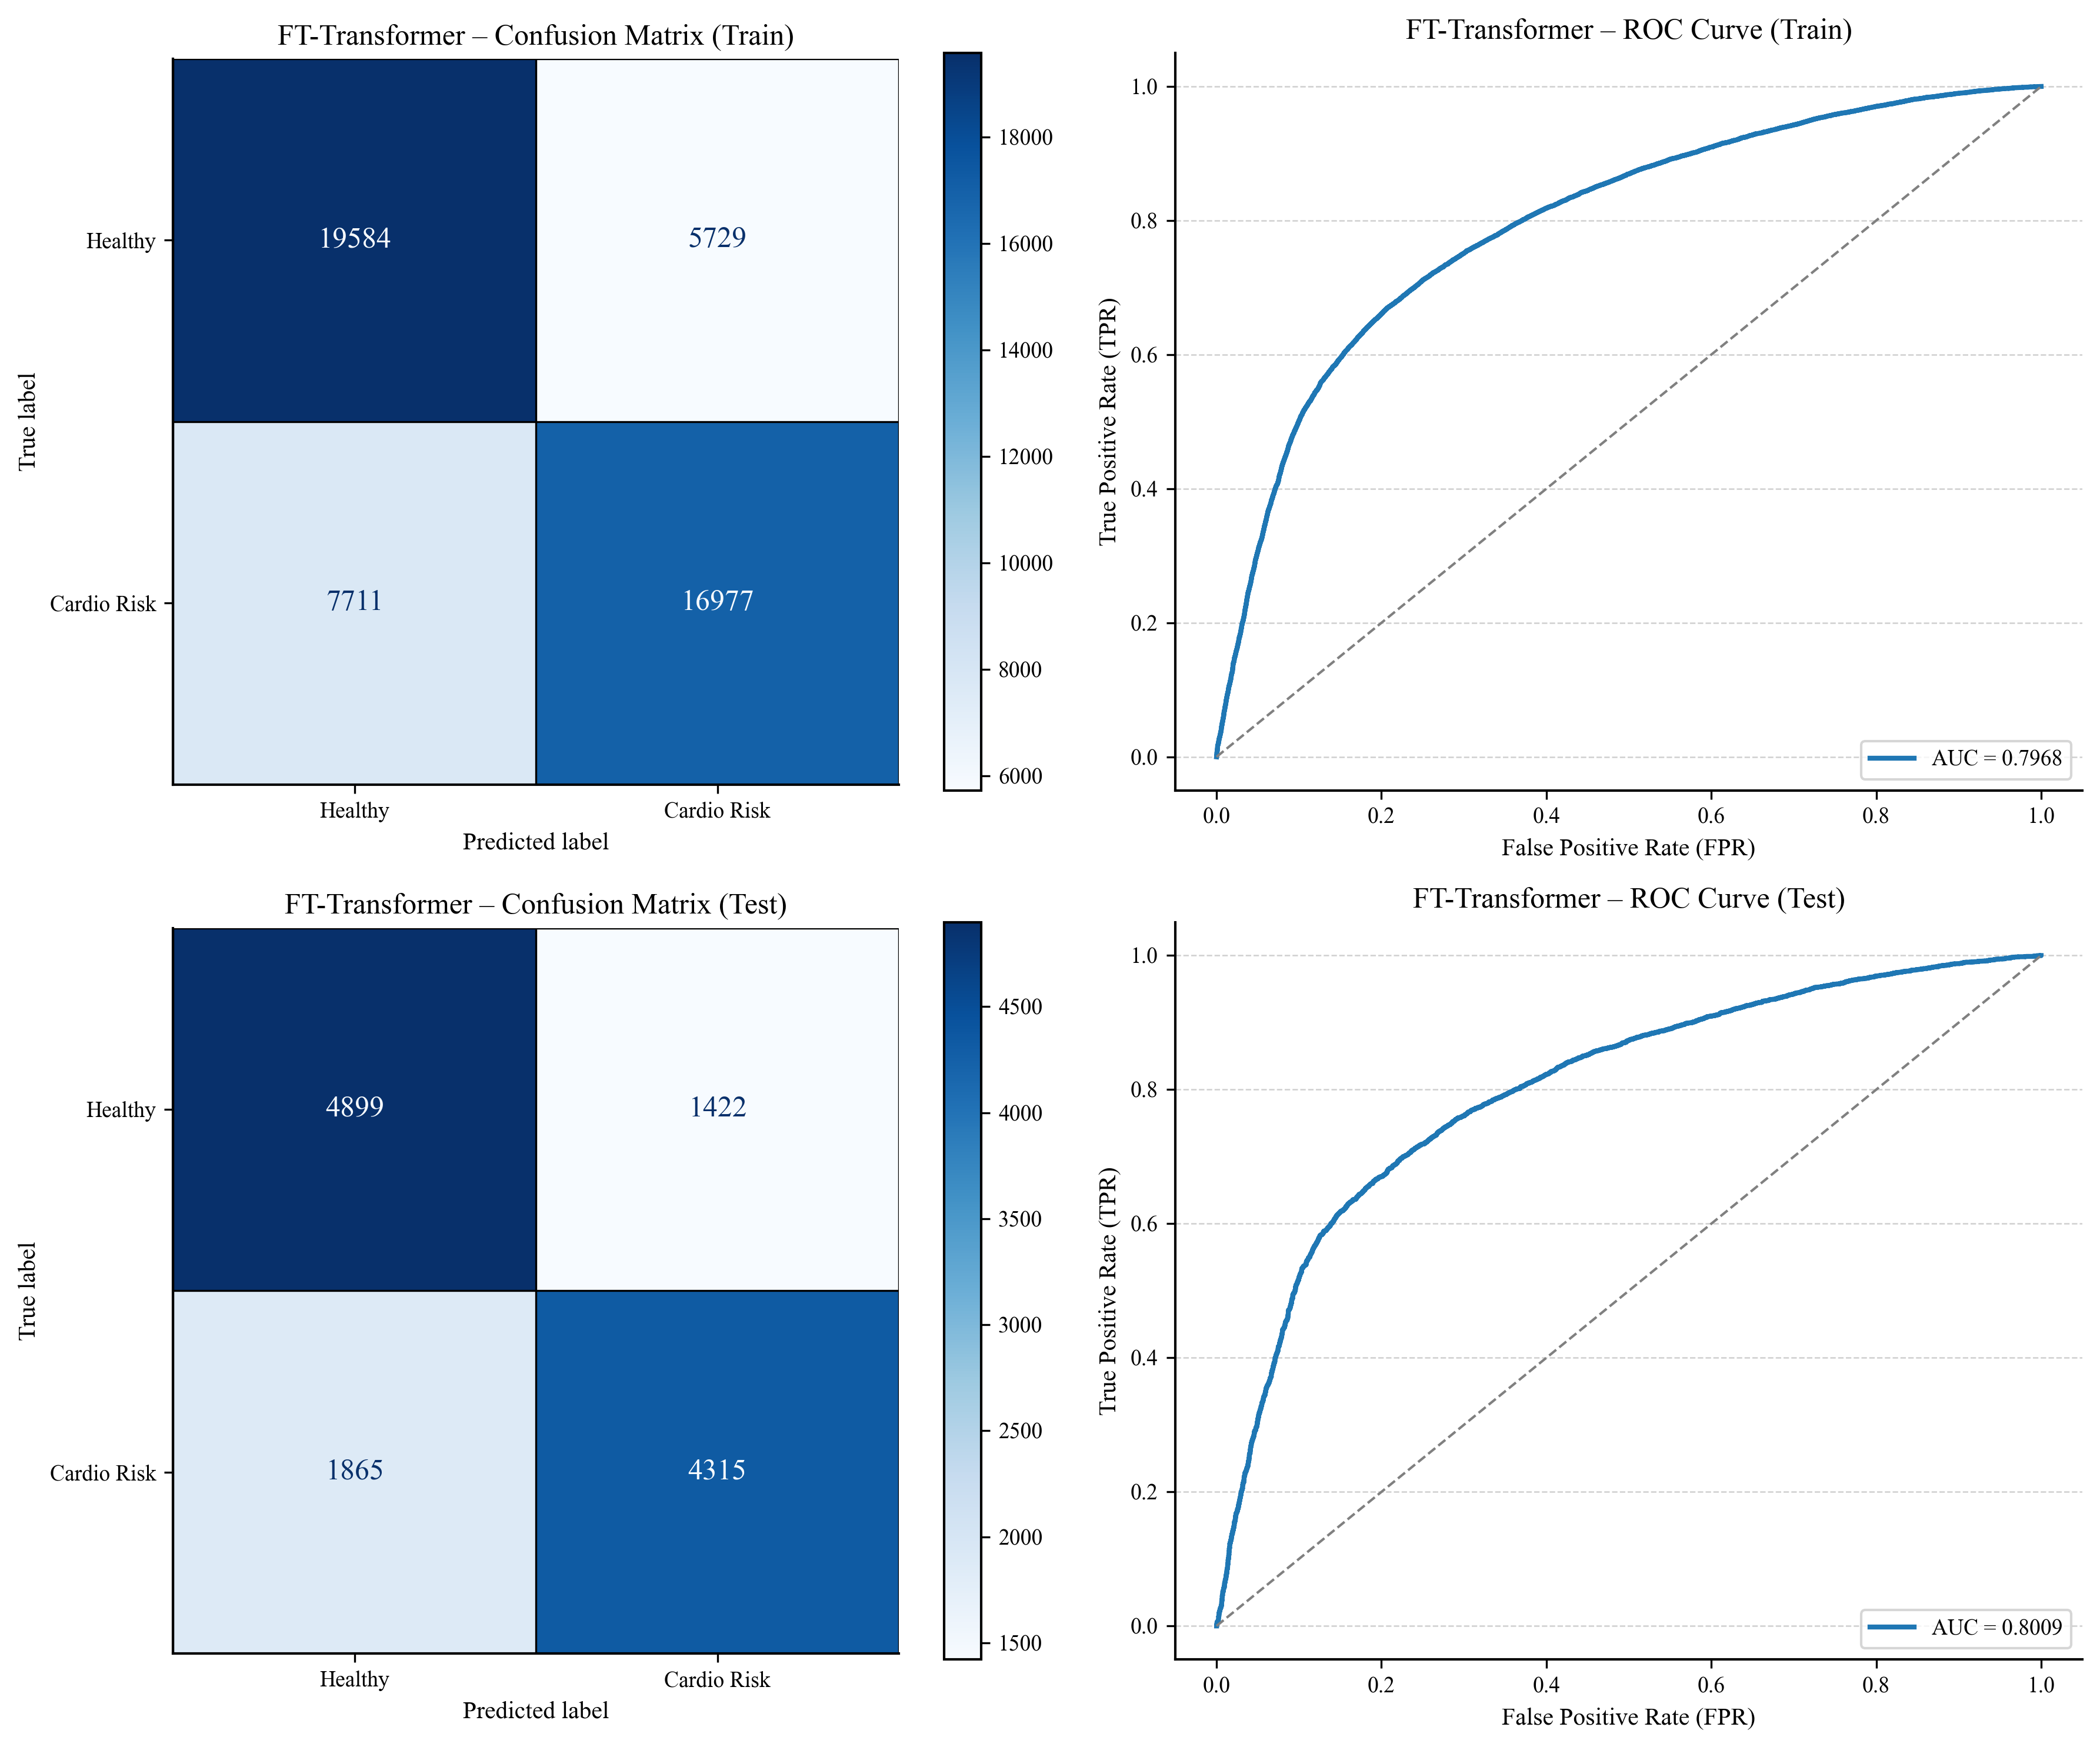

In [14]:
fttf_model = FTTransformer(
    categories          = (3, 3, 2, 2, 2, 2), 
    num_continuous      = len(continuous_indices),
    dim                 = 32,
    dim_out             = 1,
    depth               = 6,
    heads               = 8,
    attn_dropout        = 0.1,
    ff_dropout          = 0.1
).to(device)

fttf_wrapper = PyTorchClassifier(
    model               = fttf_model,
    epochs              = 10,
    batch_size          = 32,
    lr                  = 1e-3,
    categorical_indices = categorical_indices,
    continuous_indices  = continuous_indices,
)

fttf_wrapper.fit(x_train_np, y_train_np)

fttf_results = evaluate_model(
    model               = fttf_wrapper,
    model_name          = "FT-Transformer",
    plot_cm_roc         = True
    )

fttf_results;

In [15]:
base_models_ml = [
    ('lgbm', lgbm_model),
    ('cat', catb_model),
    ('hgrb', hgrb_model)
]

base_models_dl = [
    ('tabnet', tabnet_model),
    ('tabtf', tabtf_wrapper),
    ('fttf', fttf_wrapper)
]

base_models_hybird = [
    ('lgbm', lgbm_model),
    ('cat', catb_model),
    ('hgrb', hgrb_model),
    ('tabnet', tabnet_model),
    ('tabtf',tabtf_wrapper),
    ('fttf', fttf_wrapper)
]

In [16]:
meta_model = adb_model

In [17]:
stacking_model_ml = StackingClassifier(estimators=base_models_ml,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

stacking_model_dl = StackingClassifier(estimators=base_models_dl,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

stacking_model_hybird = StackingClassifier(estimators=base_models_hybird,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

In [18]:
stacking_model_ml.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('lgbm', LGBMClassifier(verbose=-1)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x7685da5474c0>),
                               ('hgrb',
                                HistGradientBoostingClassifier(random_state=42))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)


             === Stacking ML Model Results ===              
Test Acc: 0.7369, AUC: 0.8010
              precision    recall  f1-score   support

           0     0.7110    0.8083    0.7565      6321
           1     0.7720    0.6639    0.7139      6180

    accuracy                         0.7369     12501
   macro avg     0.7415    0.7361    0.7352     12501
weighted avg     0.7411    0.7369    0.7354     12501

Train Acc: 0.7440, AUC: 0.8127
              precision    recall  f1-score   support

           0     0.7152    0.8214    0.7646     25313
           1     0.7840    0.6646    0.7194     24688

    accuracy                         0.7440     50001
   macro avg     0.7496    0.7430    0.7420     50001
weighted avg     0.7492    0.7440    0.7423     50001

✅ No significant overfitting



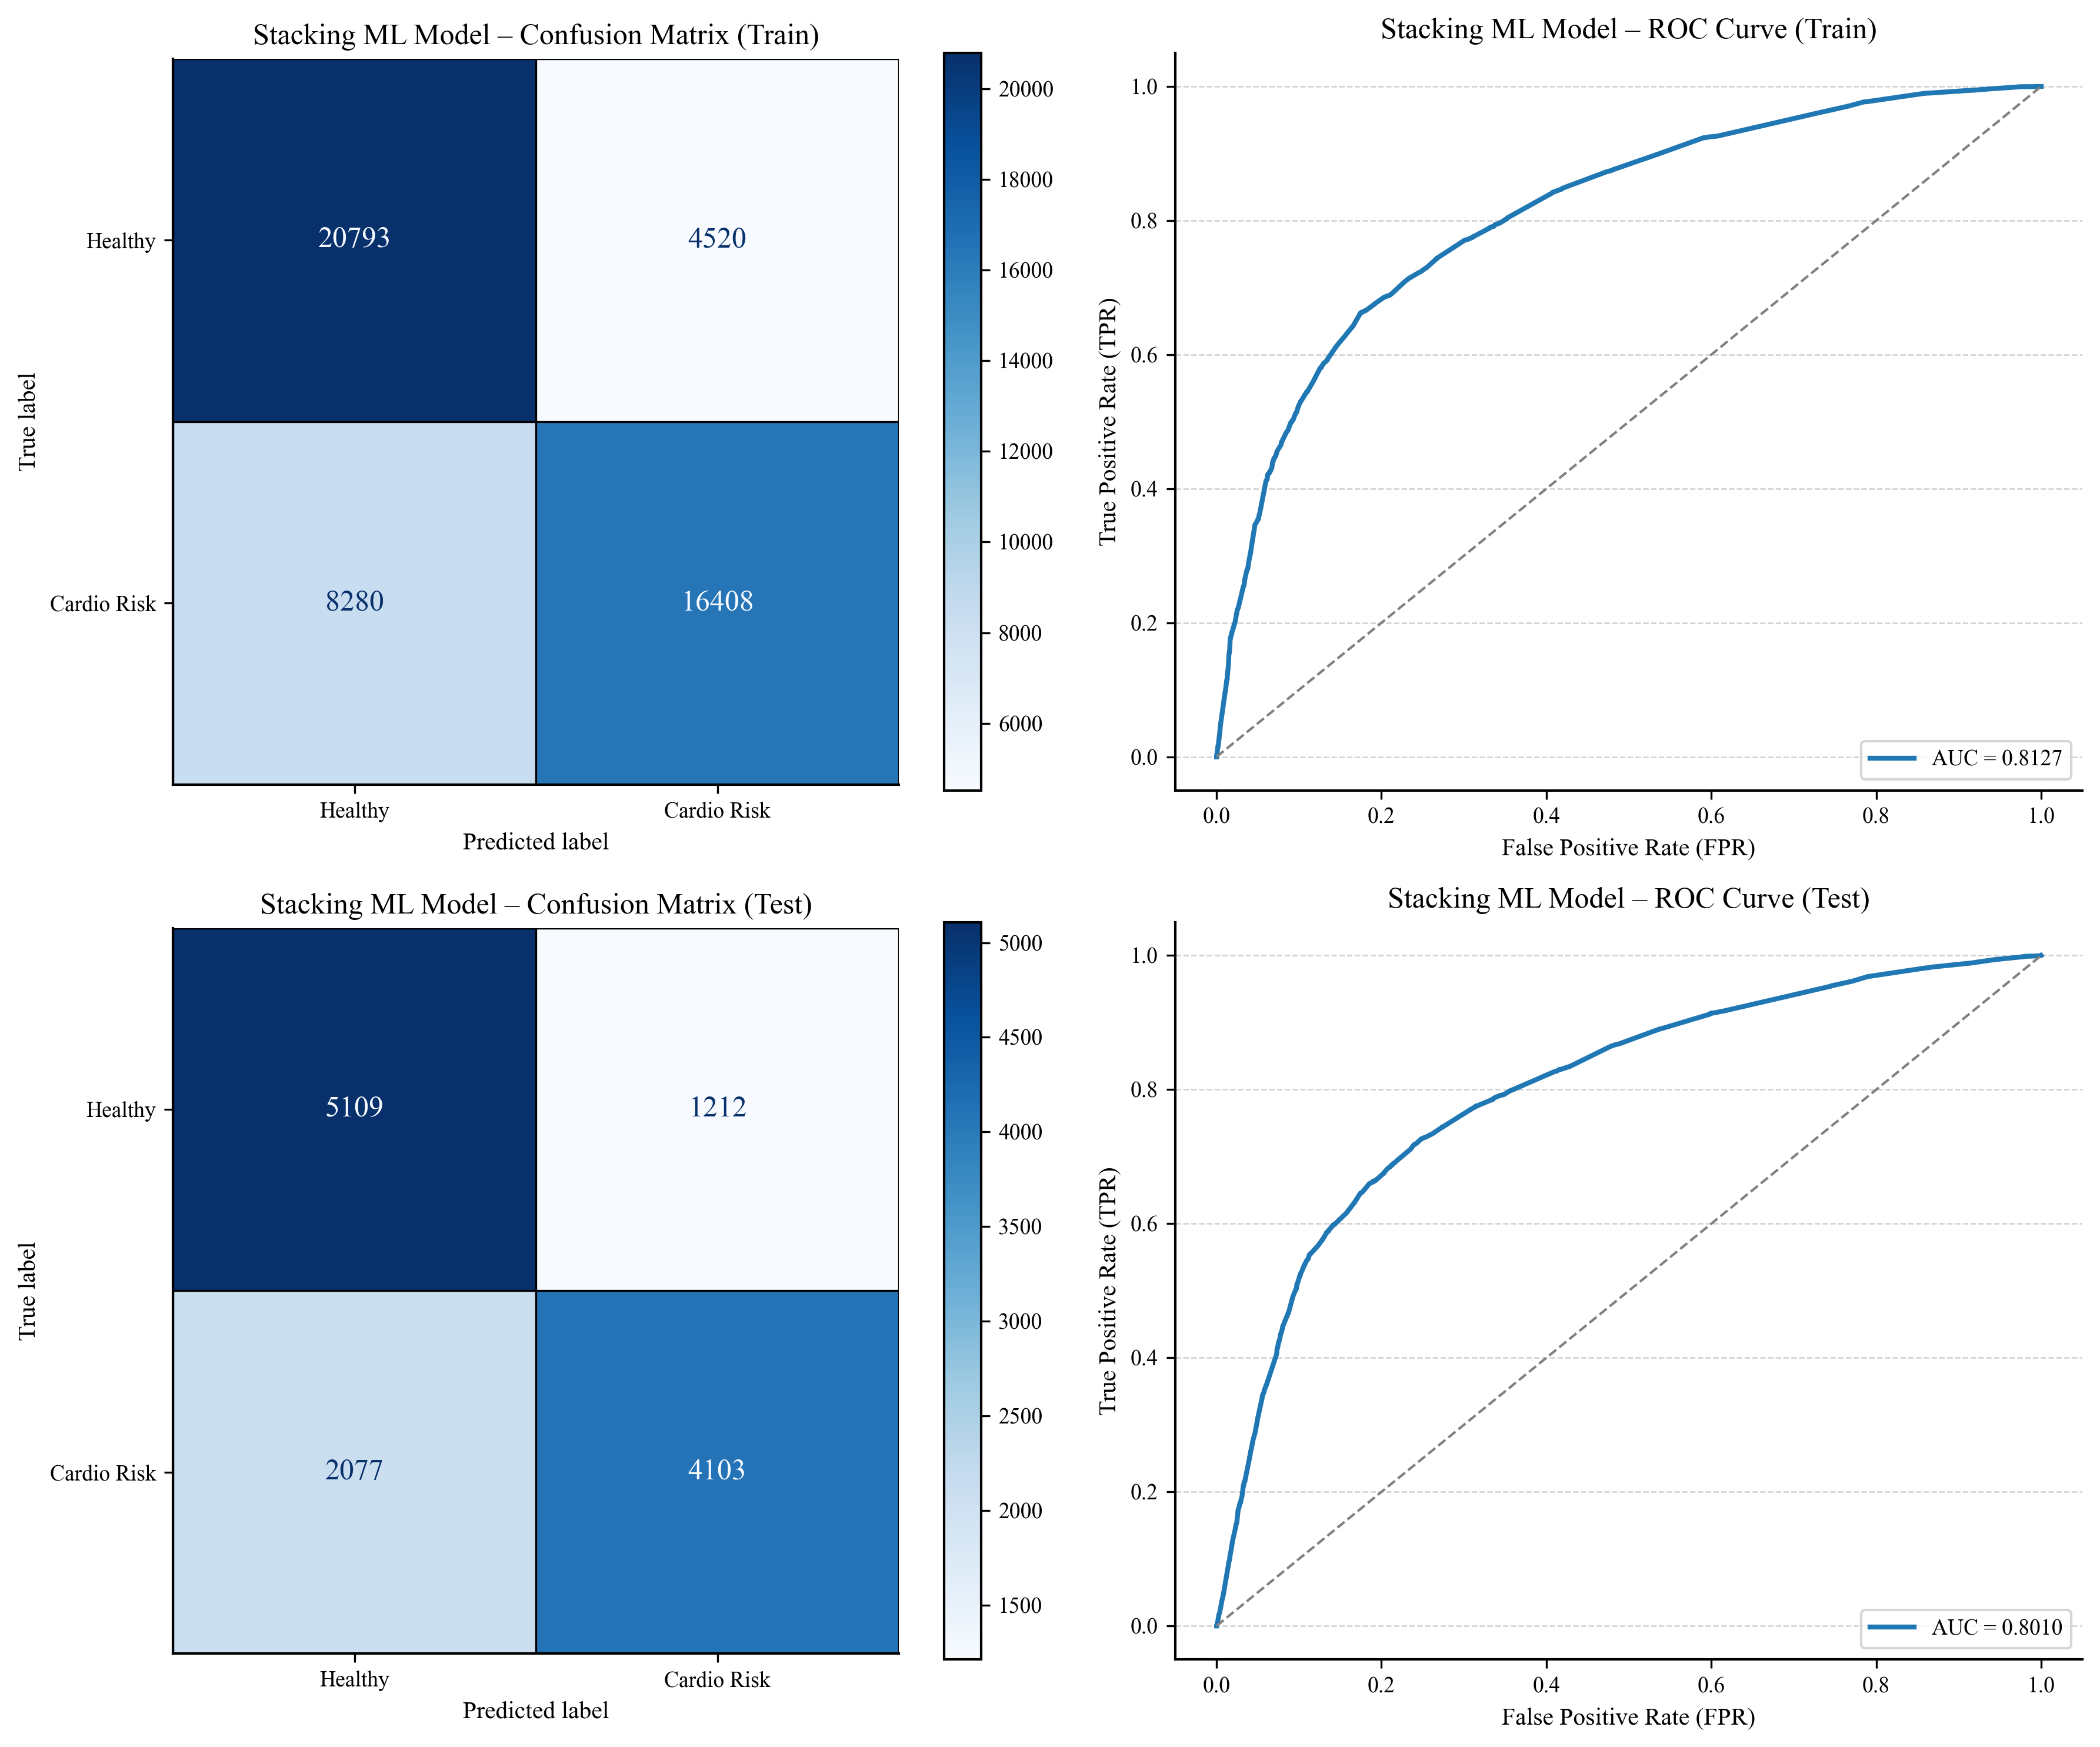

In [19]:
stacking_model_ml_results = evaluate_model(
    model               = stacking_model_ml,
    model_name          = "Stacking ML Model",
    plot_cm_roc         = True
    )

stacking_model_ml_results;

In [20]:
stacking_model_dl.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


[Wrapper] Epoch 1/10, Loss: 0.6239
[Wrapper] Epoch 2/10, Loss: 0.6212
[Wrapper] Epoch 3/10, Loss: 0.6198
[Wrapper] Epoch 4/10, Loss: 0.6175
[Wrapper] Epoch 5/10, Loss: 0.6167
[Wrapper] Epoch 6/10, Loss: 0.6161
[Wrapper] Epoch 7/10, Loss: 0.6153
[Wrapper] Epoch 8/10, Loss: 0.6142
[Wrapper] Epoch 9/10, Loss: 0.6139
[Wrapper] Epoch 10/10, Loss: 0.6518
[Wrapper] Epoch 1/10, Loss: 0.5492
[Wrapper] Epoch 2/10, Loss: 0.5490
[Wrapper] Epoch 3/10, Loss: 0.5492
[Wrapper] Epoch 4/10, Loss: 0.5490
[Wrapper] Epoch 5/10, Loss: 0.5487
[Wrapper] Epoch 6/10, Loss: 0.5486
[Wrapper] Epoch 7/10, Loss: 0.5478
[Wrapper] Epoch 8/10, Loss: 0.5477
[Wrapper] Epoch 9/10, Loss: 0.5477
[Wrapper] Epoch 10/10, Loss: 0.5468


/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/sit

[Wrapper] Epoch 1/10, Loss: 0.6238
[Wrapper] Epoch 2/10, Loss: 0.6215
[Wrapper] Epoch 3/10, Loss: 0.6197
[Wrapper] Epoch 4/10, Loss: 0.6191
[Wrapper] Epoch 5/10, Loss: 0.6174
[Wrapper] Epoch 6/10, Loss: 0.6168
[Wrapper] Epoch 7/10, Loss: 0.6153
[Wrapper] Epoch 8/10, Loss: 0.6142
[Wrapper] Epoch 9/10, Loss: 0.6130
[Wrapper] Epoch 10/10, Loss: 0.6129
[Wrapper] Epoch 1/10, Loss: 0.6243
[Wrapper] Epoch 2/10, Loss: 0.6237
[Wrapper] Epoch 3/10, Loss: 0.6232
[Wrapper] Epoch 4/10, Loss: 0.6188
[Wrapper] Epoch 5/10, Loss: 0.6184
[Wrapper] Epoch 6/10, Loss: 0.6176
[Wrapper] Epoch 7/10, Loss: 0.6198
[Wrapper] Epoch 8/10, Loss: 0.6160
[Wrapper] Epoch 9/10, Loss: 0.6157
[Wrapper] Epoch 10/10, Loss: 0.6143
[Wrapper] Epoch 1/10, Loss: 0.6246
[Wrapper] Epoch 2/10, Loss: 0.6216
[Wrapper] Epoch 3/10, Loss: 0.6193
[Wrapper] Epoch 4/10, Loss: 0.6196
[Wrapper] Epoch 5/10, Loss: 0.6167
[Wrapper] Epoch 6/10, Loss: 0.6173
[Wrapper] Epoch 7/10, Loss: 0.6158
[Wrapper] Epoch 8/10, Loss: 0.6201
[Wrapper] Epoch 9/

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('tabnet',
                                TabNetClassifier(n_d=8,
                                                 n_a=8,
                                                 n_steps=3,
                                                 gamma=1.3,
                                                 cat_idxs=[],
                                                 cat_dims=[],
                                                 cat_emb_dim=[],
                                                 n_independent=2,
                                                 n_shared=2,
                                                 epsilon=1e-15,
                                                 momentum=0.02,
                                                 lambda_sparse=0.001,
                                                 seed=0,
                                                 clip_value=1,
                                                 verbose=0,
                                                 optimizer_fn=<class 'torch.optim.adam.Adam'>,
                                                 optimizer_params={'lr': 0.02},
                                                 scheduler_fn=None,
                                                 scheduler_params={},...
            (4): Linear(in_features=128, out_features=32, bias=True)
          )
          (act): Tanh()
          (norm): RMSNorm()
          (dropout): Dropout(p=0.0, inplace=False)
          (residual_transform): Identity()
        )
      )
    )
  )
  (to_logits): Sequential(
    (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)


             === Stacking DL Model Results ===              
Test Acc: 0.7364, AUC: 0.8000
              precision    recall  f1-score   support

           0     0.7039    0.8265    0.7602      6321
           1     0.7840    0.6443    0.7073      6180

    accuracy                         0.7364     12501
   macro avg     0.7439    0.7354    0.7338     12501
weighted avg     0.7435    0.7364    0.7341     12501

Train Acc: 0.7302, AUC: 0.7986
              precision    recall  f1-score   support

           0     0.6968    0.8266    0.7562     25313
           1     0.7803    0.6313    0.6979     24688

    accuracy                         0.7302     50001
   macro avg     0.7386    0.7289    0.7271     50001
weighted avg     0.7380    0.7302    0.7274     50001

✅ No significant overfitting



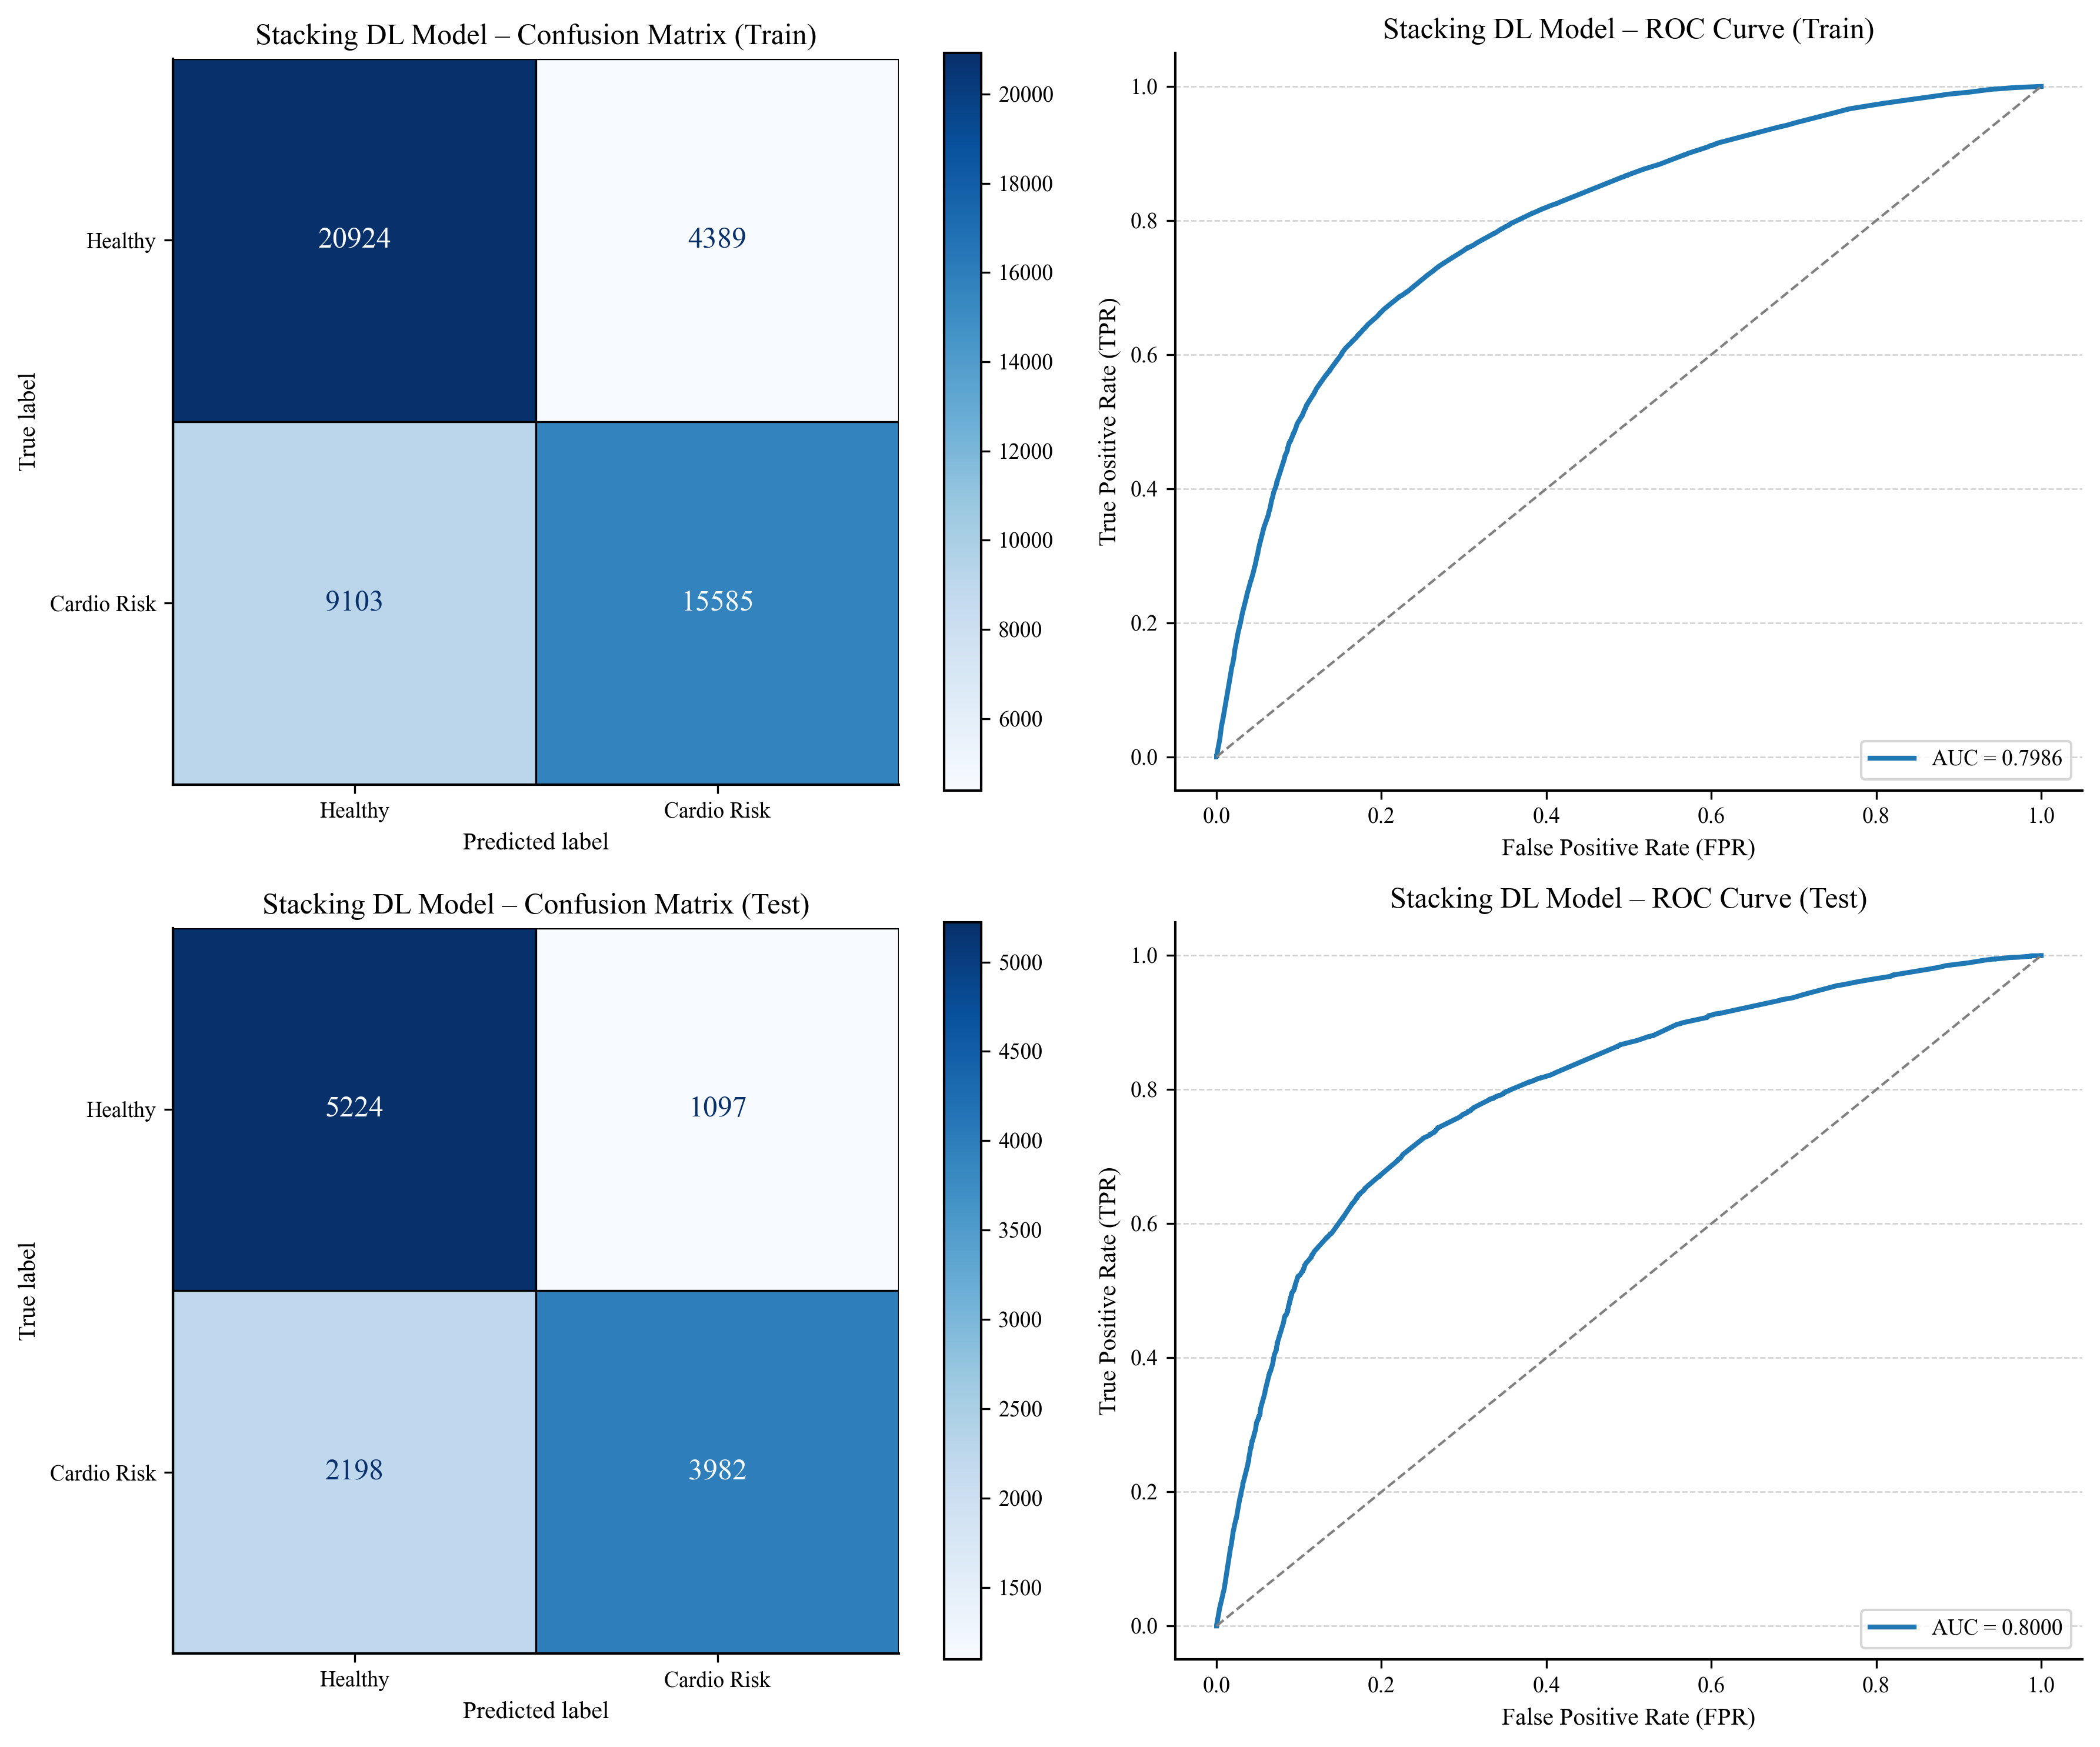

In [21]:
stacking_model_dl_results = evaluate_model(
    model               = stacking_model_dl,
    model_name          = "Stacking DL Model",
    plot_cm_roc         = True
    )

stacking_model_dl_results;


In [22]:
stacking_model_hybird.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


[Wrapper] Epoch 1/10, Loss: 0.6239
[Wrapper] Epoch 2/10, Loss: 0.6212
[Wrapper] Epoch 3/10, Loss: 0.6198
[Wrapper] Epoch 4/10, Loss: 0.6175
[Wrapper] Epoch 5/10, Loss: 0.6167
[Wrapper] Epoch 6/10, Loss: 0.6161
[Wrapper] Epoch 7/10, Loss: 0.6153
[Wrapper] Epoch 8/10, Loss: 0.6142
[Wrapper] Epoch 9/10, Loss: 0.6139
[Wrapper] Epoch 10/10, Loss: 0.6518
[Wrapper] Epoch 1/10, Loss: 0.5492
[Wrapper] Epoch 2/10, Loss: 0.5490
[Wrapper] Epoch 3/10, Loss: 0.5492
[Wrapper] Epoch 4/10, Loss: 0.5490
[Wrapper] Epoch 5/10, Loss: 0.5487
[Wrapper] Epoch 6/10, Loss: 0.5486
[Wrapper] Epoch 7/10, Loss: 0.5478
[Wrapper] Epoch 8/10, Loss: 0.5477
[Wrapper] Epoch 9/10, Loss: 0.5477
[Wrapper] Epoch 10/10, Loss: 0.5468


/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/sit

[Wrapper] Epoch 1/10, Loss: 0.6238
[Wrapper] Epoch 2/10, Loss: 0.6215
[Wrapper] Epoch 3/10, Loss: 0.6197
[Wrapper] Epoch 4/10, Loss: 0.6191
[Wrapper] Epoch 5/10, Loss: 0.6174
[Wrapper] Epoch 6/10, Loss: 0.6168
[Wrapper] Epoch 7/10, Loss: 0.6153
[Wrapper] Epoch 8/10, Loss: 0.6142
[Wrapper] Epoch 9/10, Loss: 0.6130
[Wrapper] Epoch 10/10, Loss: 0.6129
[Wrapper] Epoch 1/10, Loss: 0.6243
[Wrapper] Epoch 2/10, Loss: 0.6237
[Wrapper] Epoch 3/10, Loss: 0.6232
[Wrapper] Epoch 4/10, Loss: 0.6188
[Wrapper] Epoch 5/10, Loss: 0.6184
[Wrapper] Epoch 6/10, Loss: 0.6176
[Wrapper] Epoch 7/10, Loss: 0.6198
[Wrapper] Epoch 8/10, Loss: 0.6160
[Wrapper] Epoch 9/10, Loss: 0.6157
[Wrapper] Epoch 10/10, Loss: 0.6143
[Wrapper] Epoch 1/10, Loss: 0.6246
[Wrapper] Epoch 2/10, Loss: 0.6216
[Wrapper] Epoch 3/10, Loss: 0.6193
[Wrapper] Epoch 4/10, Loss: 0.6196
[Wrapper] Epoch 5/10, Loss: 0.6167
[Wrapper] Epoch 6/10, Loss: 0.6173
[Wrapper] Epoch 7/10, Loss: 0.6158
[Wrapper] Epoch 8/10, Loss: 0.6201
[Wrapper] Epoch 9/

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('lgbm', LGBMClassifier(verbose=-1)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x7685da5474c0>),
                               ('hgrb',
                                HistGradientBoostingClassifier(random_state=42)),
                               ('tabnet',
                                TabNetClassifier(n_d=8,
                                                 n_a=8,
                                                 n_steps=3,
                                                 gamma=1.3,
                                                 cat_idxs=[],
                                                 cat_dims=[],
                                                 cat_emb_dim=[],
                                                 n_independent=2,
                                                 n_shared=2,
                                                 epsilon=1e-15,
                                                 momentum=0.02,
                                                 lam...
            (4): Linear(in_features=128, out_features=32, bias=True)
          )
          (act): Tanh()
          (norm): RMSNorm()
          (dropout): Dropout(p=0.0, inplace=False)
          (residual_transform): Identity()
        )
      )
    )
  )
  (to_logits): Sequential(
    (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)


           === Hybird Stacking Model Results ===            
Test Acc: 0.7363, AUC: 0.8005
              precision    recall  f1-score   support

           0     0.7051    0.8225    0.7593      6321
           1     0.7812    0.6482    0.7085      6180

    accuracy                         0.7363     12501
   macro avg     0.7432    0.7354    0.7339     12501
weighted avg     0.7427    0.7363    0.7342     12501

Train Acc: 0.7337, AUC: 0.8076
              precision    recall  f1-score   support

           0     0.7013    0.8255    0.7583     25313
           1     0.7814    0.6395    0.7034     24688

    accuracy                         0.7337     50001
   macro avg     0.7413    0.7325    0.7309     50001
weighted avg     0.7408    0.7337    0.7312     50001

✅ No significant overfitting



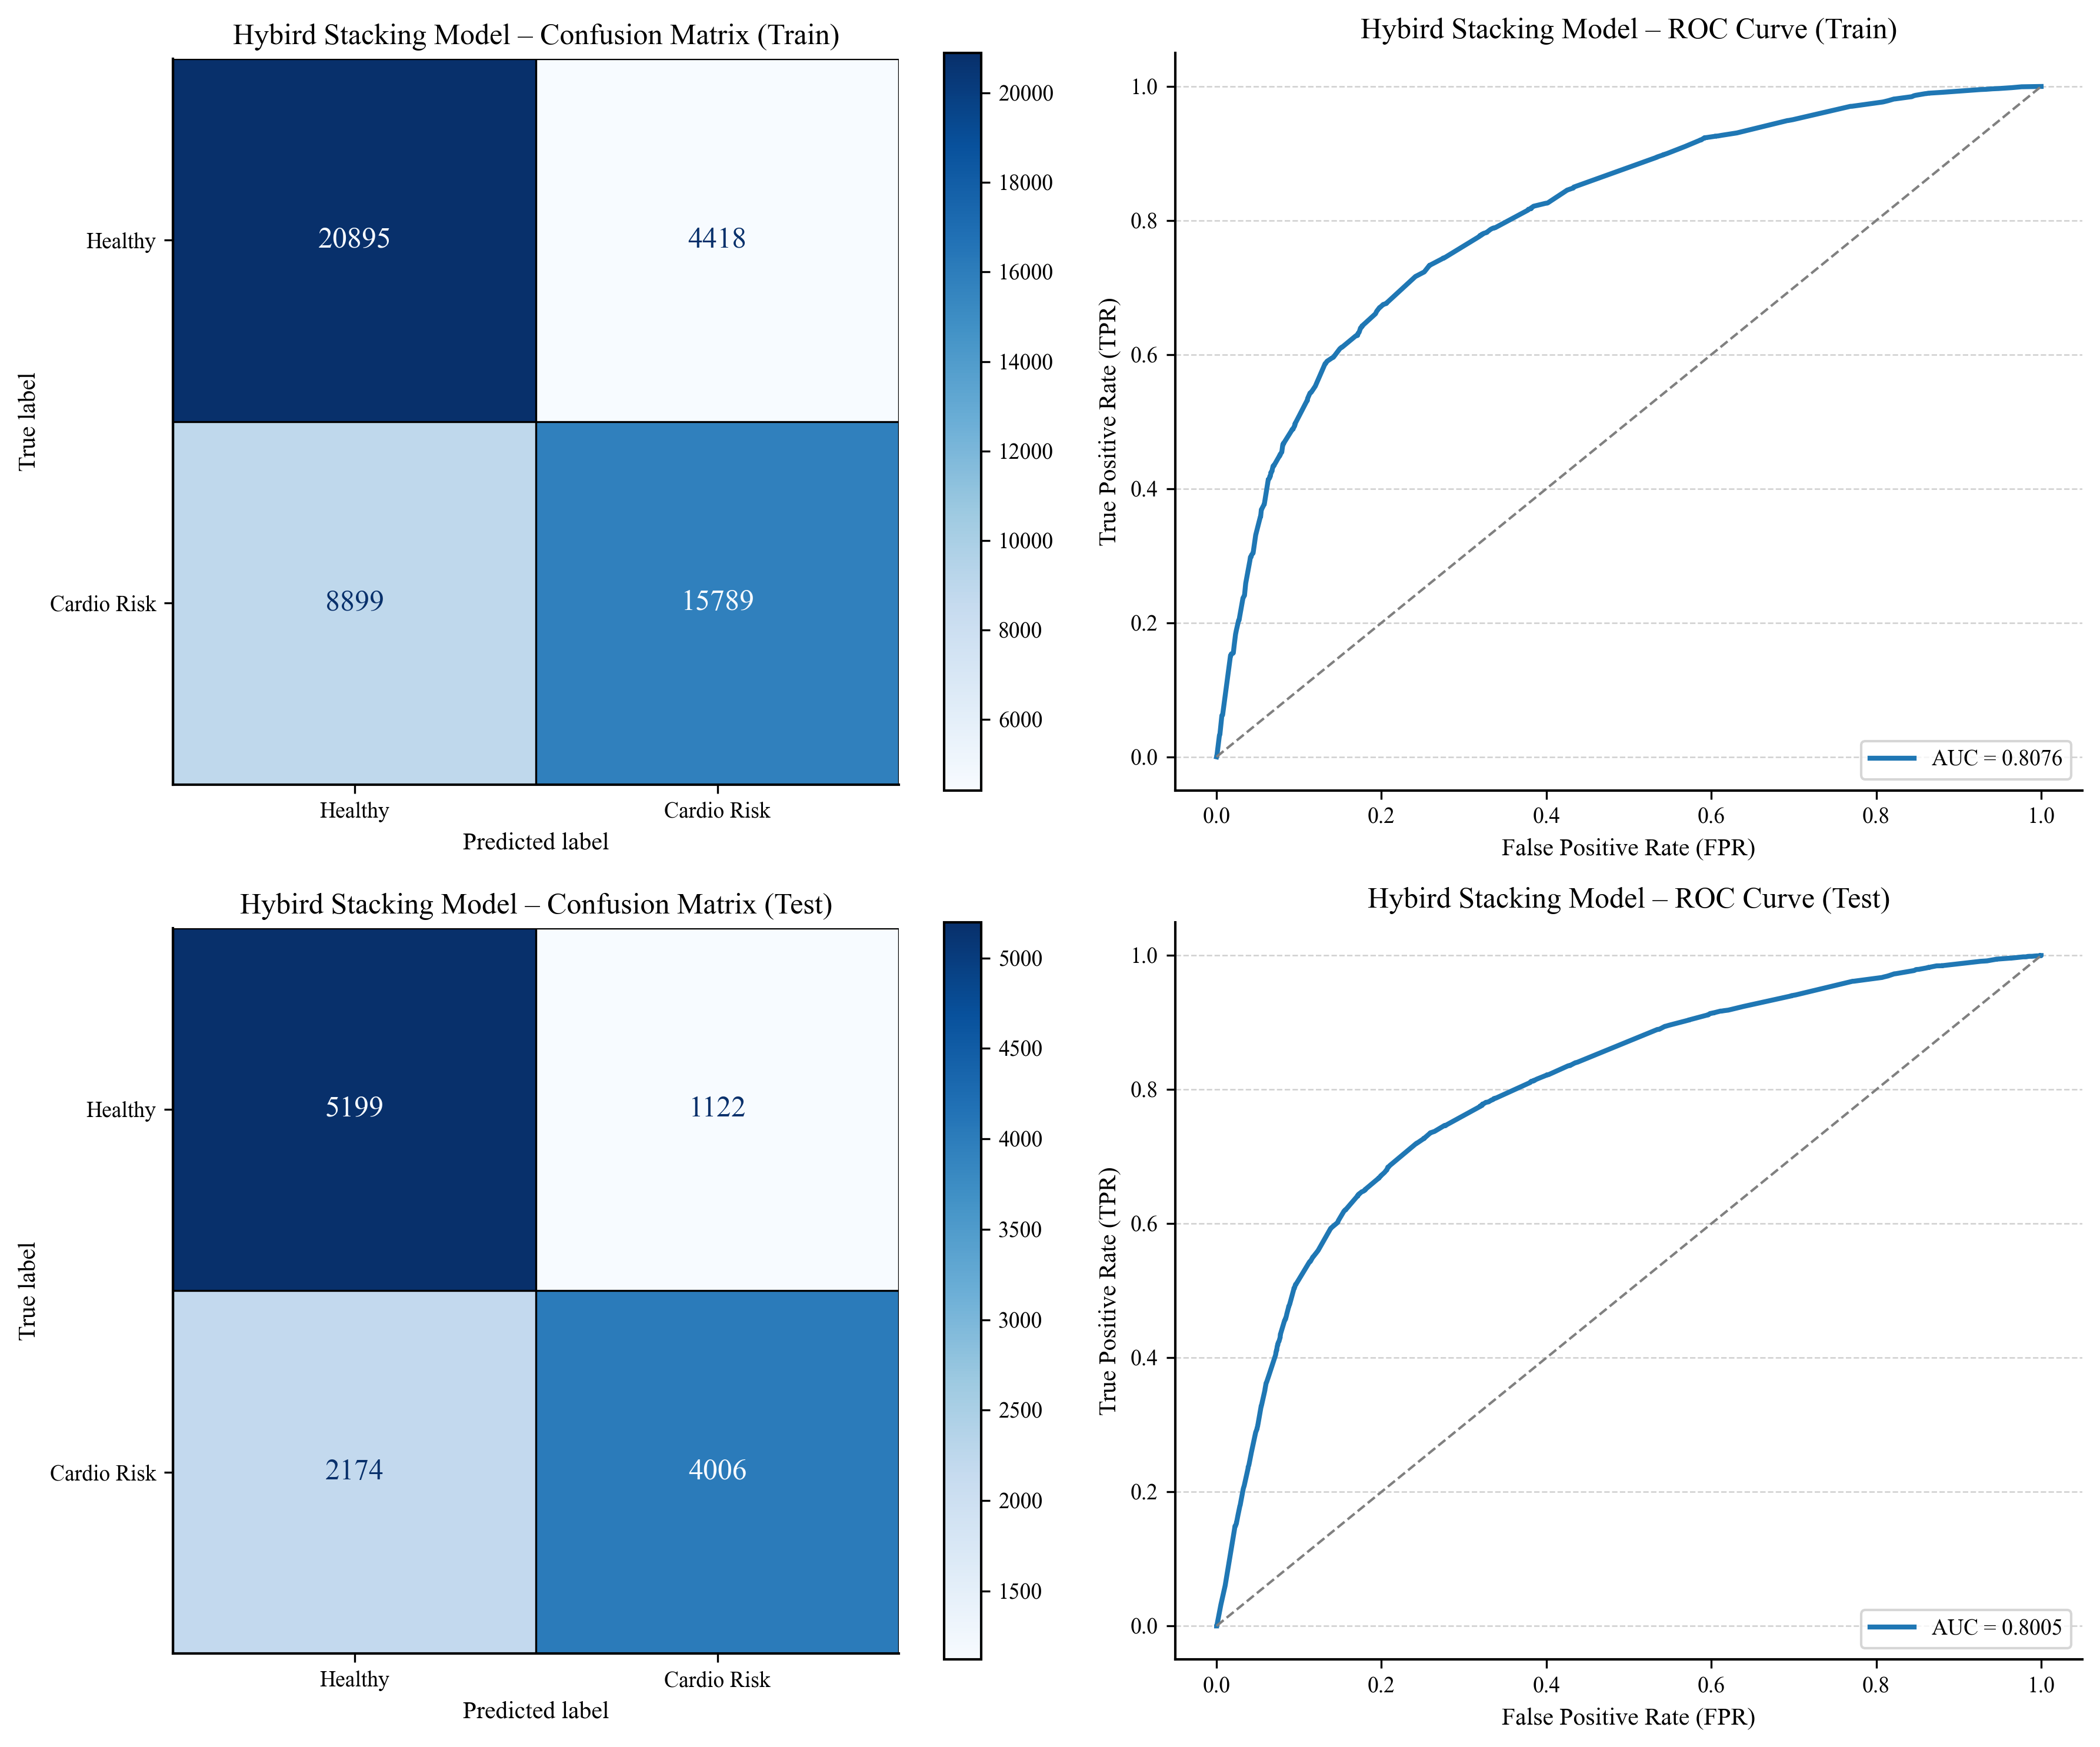

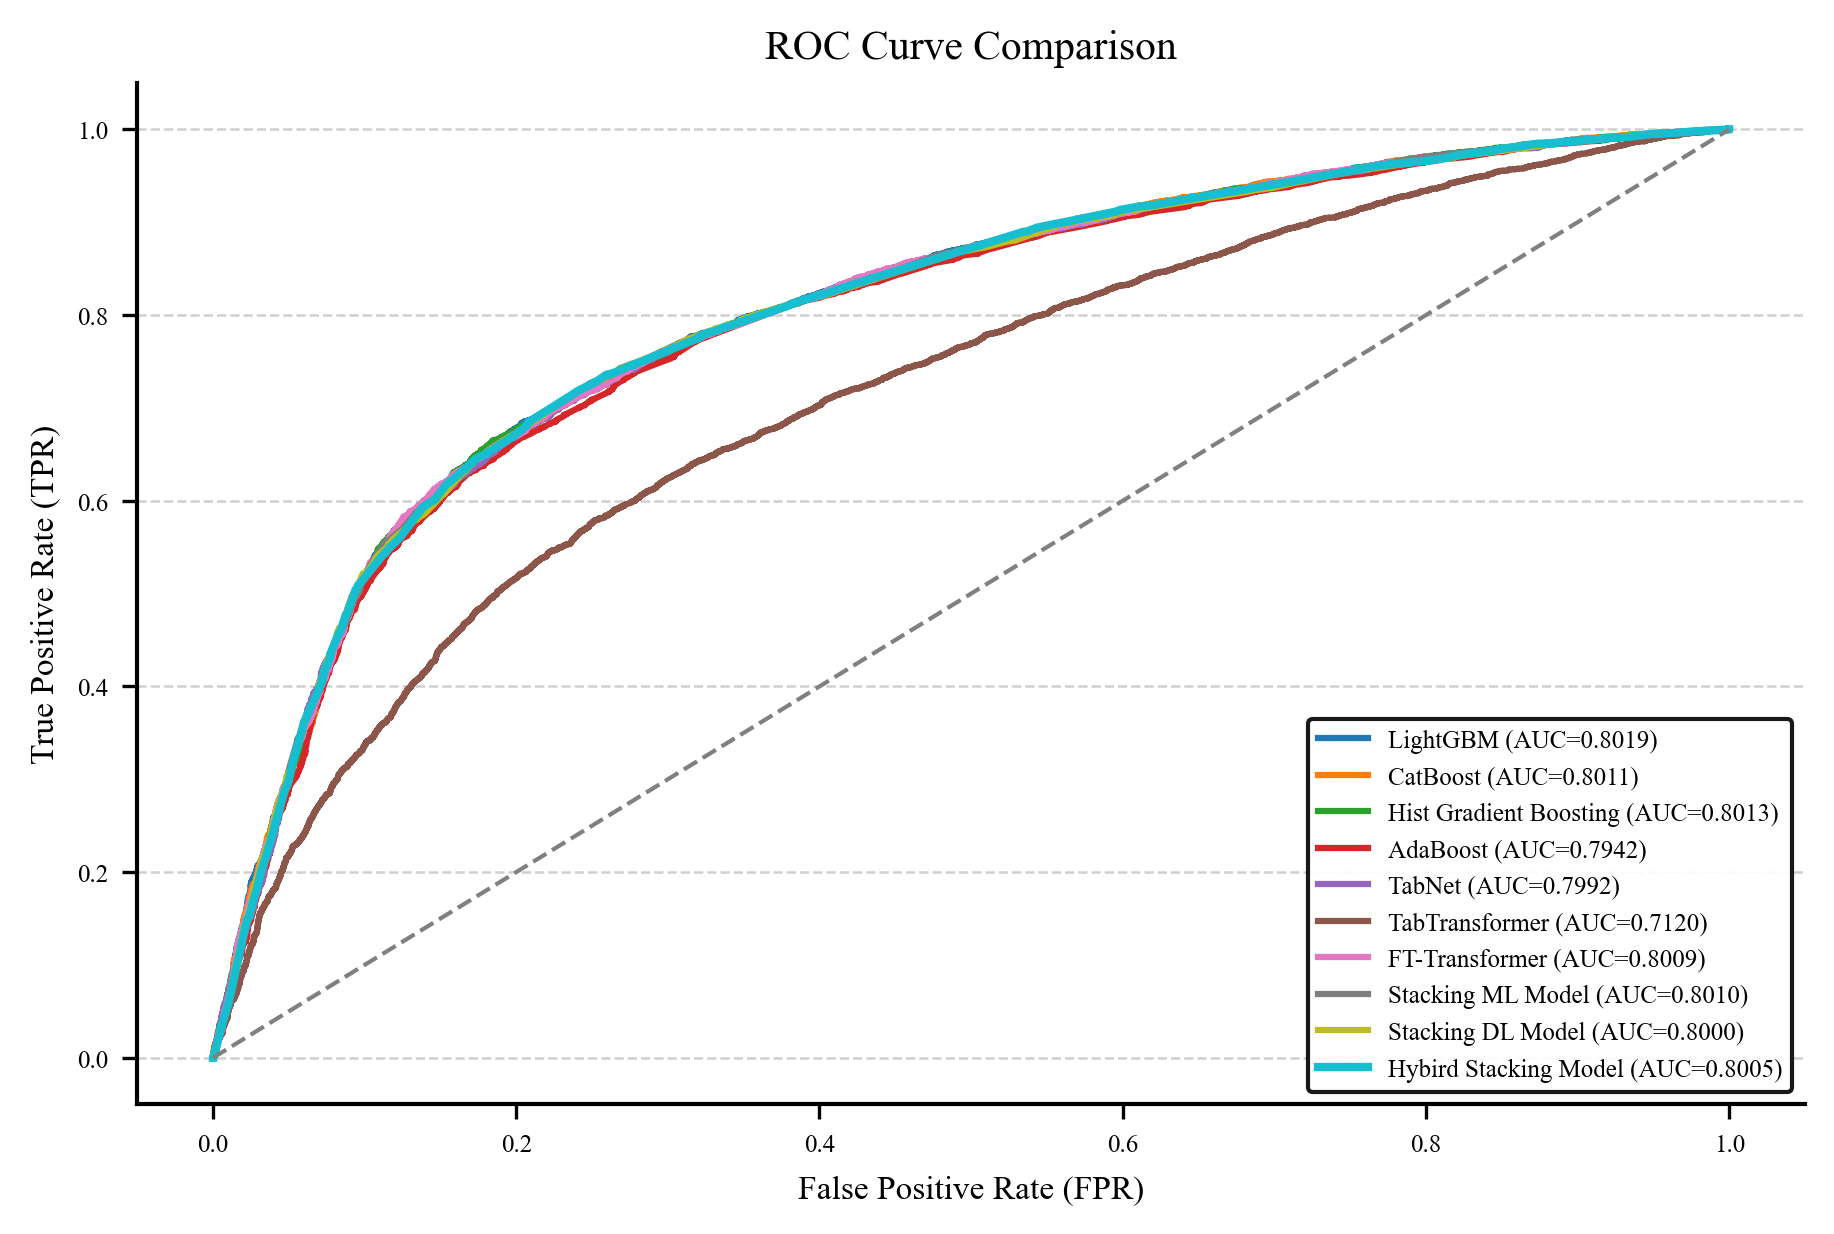

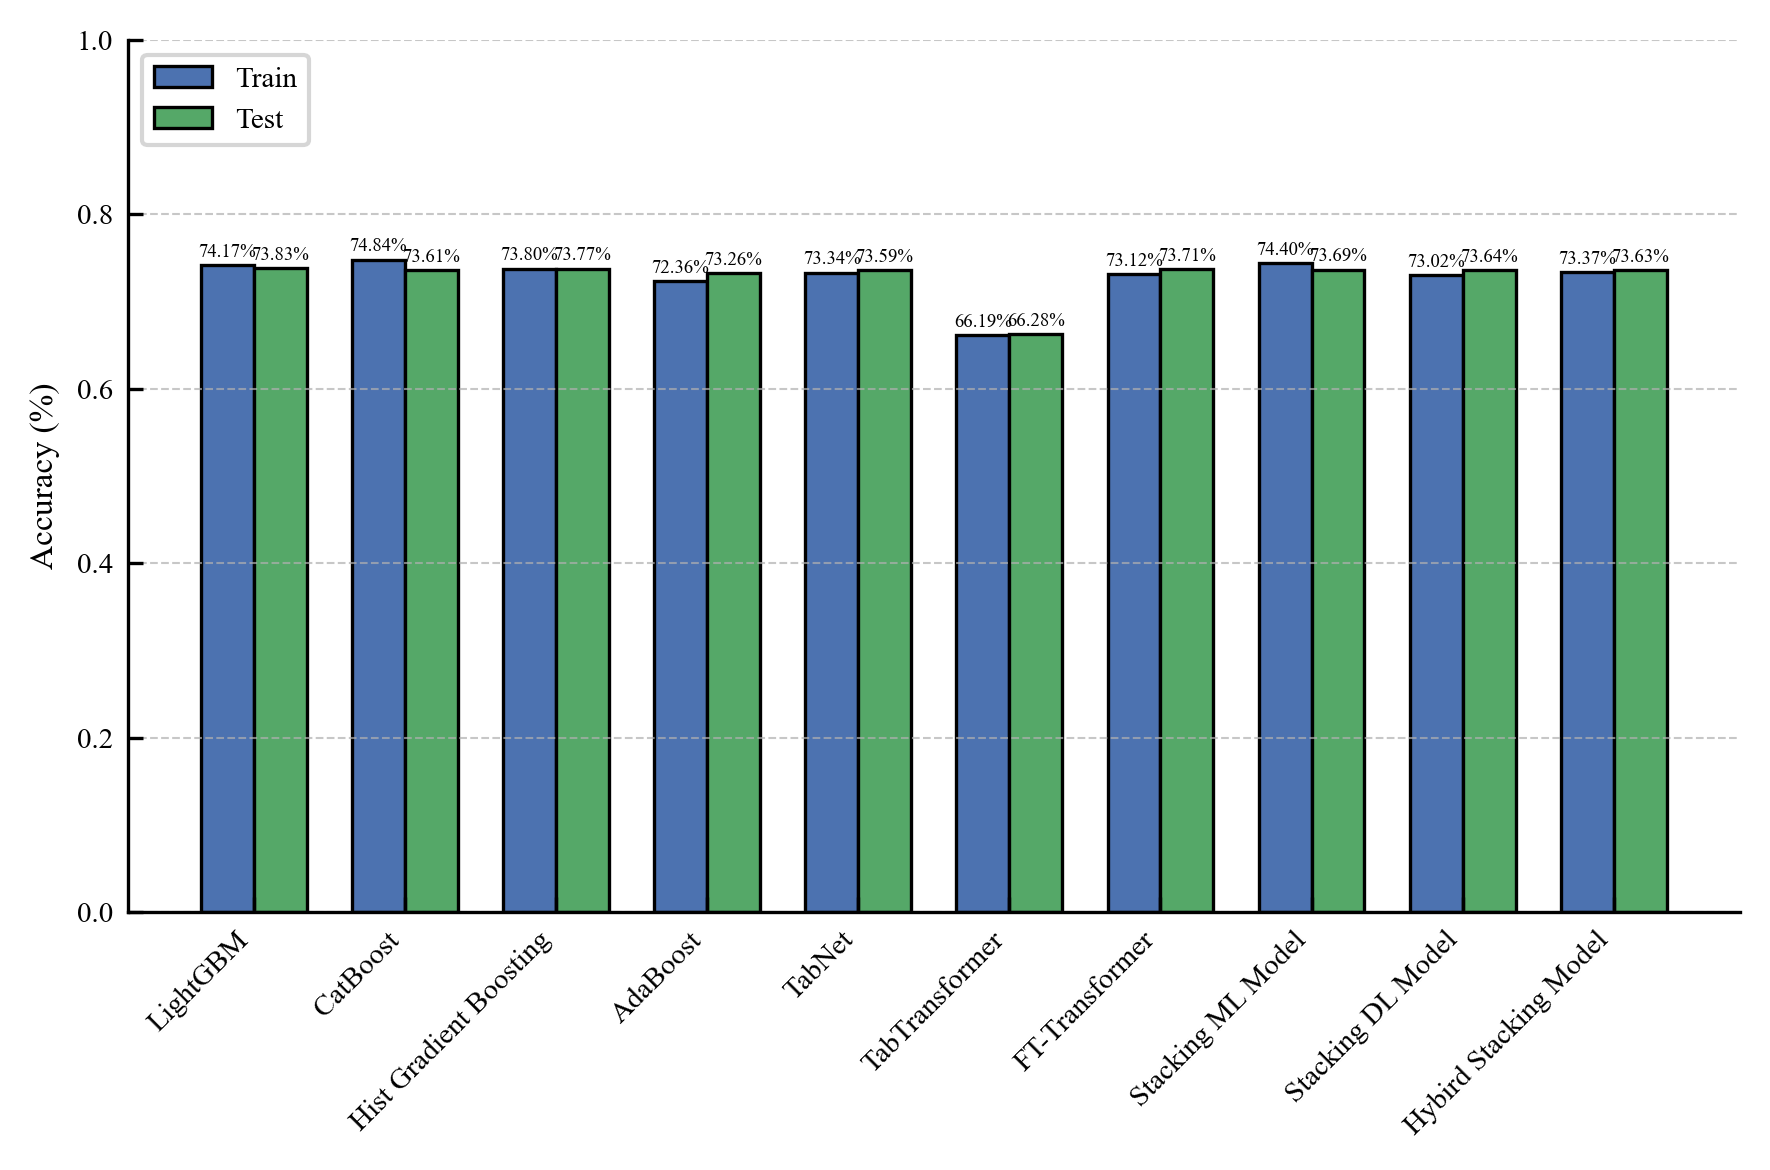

In [23]:
compare = {
            'LightGBM': lgbm_model,
            'CatBoost': catb_model,
            'Hist Gradient Boosting' : hgrb_model,
            'AdaBoost': adb_model,
            'TabNet' : tabnet_model,
            'TabTransformer': tabtf_wrapper,
            'FT-Transformer': fttf_wrapper,
            'Stacking ML Model': stacking_model_ml,
            'Stacking DL Model': stacking_model_dl
        }

stacking_model_hybrid_results = evaluate_model(
    model               = stacking_model_hybird,
    model_name          = "Hybird Stacking Model",
    plot_cm_roc         = True,
    summary             = compare,
    roc_auc             = compare,
    plot_acc            = compare
    )

stacking_model_hybrid_results;


In [24]:
# y_pred = stacking_model.predict(x_test_np)

# accuracy = accuracy_score(y_test_np, y_pred)
# report = classification_report(y_test_np, y_pred)

# print("Accuracy:", accuracy)
# print("\nClassification Report:\n", report)

In [25]:
# import numpy as np
# from scipy.stats import pearsonr

# # Misal, prediksi probabilitas dari base model disimpan dalam dictionary
# # Prediksi base model harus berupa array 1 dimensi (misalnya, probabilitas kelas positif)
# preds_lgbm = lgbm_model.predict_proba(x_test_np)[:, 1]
# preds_cat = catb_model.predict_proba(x_test_np)[:, 1]
# preds_hgrb = hgrb_model.predict_proba(x_test_np)[:, 1]
# preds_tabnet = tabnet_model.predict_proba(x_test_np)[:, 1]

# # Menyimpan semua prediksi di dalam array
# all_preds = np.vstack([preds_lgbm, preds_cat, preds_hgrb, preds_tabnet])

# # Menghitung korelasi antar model
# n_models = all_preds.shape[0]
# for i in range(n_models):
#     for j in range(i+1, n_models):
#         corr_coef, _ = pearsonr(all_preds[i], all_preds[j])
#         print(f"Korelasi antara model {i} dan model {j}: {corr_coef:.3f}")


In [26]:
# numerical_features = ['age', 'height', 'weight', 'systolic', 'diastolic', 'bmi', 'map', 'pulse_pressure']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features)
#     ],
#     remainder='passthrough' 
# )

# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', stacking_model)
# ])

# pipeline.fit(X_train, y_train)

# with open("pkl/ml_ensemble_model.pkl", "wb") as f:
#     pickle.dump(pipeline, f)

# print("Pipeline telah disimpan dalam file 'ml_ensemble_model_v2.pkl'.")

In [27]:
# with open('pkl/ml_ensemble_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

# # Lakukan prediksi menggunakan CPU
# y_pred = loaded_model.predict(X_test)

# # Menghitung dan menampilkan accuracy score
# acc = accuracy_score(y_test, y_pred)
# print("Akurasi model:", acc)

In [28]:
# data_new = {
#     'age':       [30, 35, 40, 45, 50, 60, 65, 70, 55, 68],   
#     'height':    [175, 180, 170, 165, 160, 158, 155, 150, 165, 160], 
#     'weight':    [68, 75, 72, 80, 85, 90, 95, 100, 78, 82], 
#     'systolic':  [110, 115, 120, 125, 130, 140, 150, 160, 115, 135],  
#     'diastolic': [70, 75, 80, 85, 90, 95, 100, 105, 75, 88],         
#     'gender':       [0, 0, 1, 0, 1, 1, 1, 1, 0, 1], # gender: 0 untuk nilai asli 1, 1 untuk nilai asli 2
#     'cholesterol':  [0, 0, 1, 1, 2, 2, 2, 2, 0, 2], # cholesterol: 0 untuk nilai asli 1, 1 untuk nilai asli 2, 2 untuk nilai asli 3
#     'gluc':         [0, 0, 1, 1, 1, 2, 2, 2, 0, 2], # gluc: 0 untuk nilai asli 1, 1 untuk nilai asli 2, 2 untuk nilai asli 3
#     'smoke':        [0, 0, 0, 0, 1, 1, 1, 1, 0, 1],
#     'alco':         [0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
#     'active':       [1, 1, 1, 1, 0, 0, 0, 0, 1, 0]
# }

# new_df = pd.DataFrame(data_new)

# valid_gender      = new_df['gender'].isin([0, 1])
# valid_cholesterol = new_df['cholesterol'].isin([0, 1, 2])
# valid_gluc        = new_df['gluc'].isin([0, 1, 2])
# valid_smoke       = new_df['smoke'].isin([0, 1])
# valid_alco        = new_df['alco'].isin([0, 1])
# valid_active      = new_df['active'].isin([0, 1])

# if not (valid_gender.all() and valid_cholesterol.all() and valid_gluc.all() and 
#         valid_smoke.all() and valid_alco.all() and valid_active.all()):
#     raise ValueError("Terdapat nilai kategori yang tidak valid pada input data.")

# new_df["bmi"] = round(new_df["weight"] / ((new_df["height"] / 100) ** 2), 2)
# new_df["map"] = round((new_df["systolic"] + 2 * new_df["diastolic"]) / 3, 2)
# new_df["pulse_pressure"] = new_df["systolic"] - new_df["diastolic"]

# expected_order = [
#     'age', 'height', 'weight', 'systolic', 'diastolic', 
#     'bmi', 'map', 'pulse_pressure',
#     'gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'
# ]
# new_df = new_df[expected_order]

# with open("pkl/ml_ensemble_model.pkl", "rb") as f:
#     pipeline = pickle.load(f)

# predictions = pipeline.predict(new_df)

# print("Input Data Baru (setelah pembuatan fitur turunan dan validasi):")
# print(new_df)
# print("\nHasil Prediksi untuk 10 contoh data:")
# print("Prediksi status cardio untuk data baru:", predictions)


In [29]:
# stacking_results = evaluate_model(stacking_model, x_train_np, y_train, x_test_np, y_test, "Stacking Ensemble Classifier")
# stacking_results;

In [30]:
# results = [lgbm_results, xgb_results, catb_results, 
#         snb_results, grb_results, hgrb_results, stacking_results
#         ]

# create_summary_table(results)